In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torch.nn.init import orthogonal_
import torch.linalg
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings from scikit-learn
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
import random
## Setting seed for reproducability
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
pip install sktime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


## First we implement all the algorithms in code: NW-RNN, NW-ESN, RNN and ESN, then run these algorithms on 4 different datasets: FordA, Synthetic Control, ECG5000 and Earthquakes, 2 of which are shown here

## NWCell Network

In [5]:
class NWCell(nn.Module):
    """
    Implements a single step of the Nanowire Neural Network cell.
    Based on Equations 7-11 from the paper.
    """
    def __init__(self, input_size, hidden_size, hp):
        super(NWCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # --- Weights and Biases ---
        # W_x * x(t+1) [cite: 85]
        self.W_x = nn.Linear(input_size, hidden_size, bias=True) 
        # W_h * h(t) [cite: 85]
        # Note: The paper adds the bias 'b' to the sum[cite: 85],
        # so we only add bias to one of the linear layers (W_x here).
        self.W_h = nn.Linear(hidden_size, hidden_size, bias=False)

        # --- Nanowire Hyperparameters [cite: 93, 128] ---
        self.Kp0 = hp['Kp0']
        self.Kd0 = hp['Kd0']
        self.eta_p = hp['eta_p']
        self.eta_d = hp['eta_d']
        self.delta_t = hp['delta_t']
        self.gamma = hp['gamma']
        
        # --- RESCALE Hyperparameters (Eq. 11) [cite: 102, 103] ---
        self.rescale_a = hp.get('rescale_a', 0.35)
        self.rescale_b = hp.get('rescale_b', 1.15)
        self.rescale_s = hp['rescale_s']

    def rescale(self, y):
        """
        Implements the RESCALE function (Eq. 11) [cite: 100-103].
        Uses torch.sigmoid(y*s) which is equivalent to 1 / (1 + exp(-y*s)).
        """
        return (self.rescale_b - self.rescale_a) * torch.sigmoid(y * self.rescale_s) + self.rescale_a

    def forward(self, input, hx):
        """
        Performs one time step.
        :param input: x(t+1), tensor of shape (batch_size, input_size)
        :param hx: h(t), tensor of shape (batch_size, hidden_size)
        :return: h(t+1), tensor of shape (batch_size, hidden_size)
        """
        
        # 1. Calculate z(t+1) = W_h*h(t) + W_x*x(t+1) + b
        #    (Eq. 7) [cite: 85]
        z_t1_affine = self.W_h(hx) + self.W_x(input)
        
        # 2. Apply RESCALE
        #    z(t+1) = RESCALE(...) (Eq. 7) [cite: 85, 98]
        z_t1 = self.rescale(z_t1_affine)
        
        # 3. Calculate potentiation and depression rates
        #    (Eq. 5, 6) [cite: 58, 59]
        Kp = self.Kp0 * torch.exp(self.eta_p * z_t1)
        Kd = self.Kd0 * torch.exp(-self.eta_d * z_t1)

        # 4. Calculate r(t+1)
        #    This combines Eq. 8 and 9 [cite: 86, 87]
        #    r(t+1) = Kp(z) - q(t+1)
        #    q(t+1) = (Kp(z) + Kd(z)) * h(t)
        #    So: r(t+1) = Kp(z) - (Kp(z) + Kd(z)) * h(t)
        #    r(t+1) = Kp(z) * (1 - h(t)) - Kd(z) * h(t)
        #    This matches the continuous form in Eq. 4 [cite: 57]
        r_t1 = Kp * (1.0 - hx) - Kd * hx
        
        # 5. Calculate the next hidden state h(t+1)
        #    (Eq. 10) [cite: 88]
        h_t1 = self.gamma * hx + r_t1 * self.delta_t
        
        # Ensure state h stays within [0, 1] as mentioned in [cite: 48, 62]
        # This is a practical constraint to maintain stability
        h_t1_clipped = torch.clamp(h_t1, 0.0, 1.0)

        return h_t1_clipped

In [6]:
class NW_Network(nn.Module):
    """
    A full Nanowire Network model that processes sequences.
    This can be configured as an NW-RNN (fully trainable) or
    an NW-ESN (fixed reservoir).
    """
    def __init__(self, input_size, hidden_size, output_size, hp):
        super(NW_Network, self).__init__()
        self.hidden_size = hidden_size
        self.cell = NWCell(input_size, hidden_size, hp)
        
        # Readout layer applied to the final state 
        self.readout = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        """
        Processes a batch of sequences.
        :param x: Input tensor of shape (batch_size, seq_length, input_size)
        :param h0: (Optional) Initial hidden state
        :return: Output tensor of shape (batch_size, output_size)
        """
        batch_size = x.size(0)
        seq_length = x.size(1)

        # Initialize hidden state h(0)
        if h0 is None:
            h = torch.full((batch_size, self.hidden_size), 0.5, device=x.device)
        else:
            h = h0

        # Loop over the sequence
        for t in range(seq_length):
            h = self.cell(x[:, t, :], h)
            
        output = self.readout(h)
        
        return output


In [7]:
def count_parameters(model):
    """Counts the total and trainable parameters of a PyTorch model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

## RNN model

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
class StandardRNN(nn.Module):
    """
    A standard RNN model for comparison.
    Uses nn.RNN with 'tanh' nonlinearity and a readout on the final hidden state.
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Standard PyTorch RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True, # Expects (batch, seq, feature)
            nonlinearity='tanh'
        )
        
        # Readout layer applied to the final state
        self.readout = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        """
        Processes a batch of sequences.
        :param x: Input tensor of shape (batch_size, seq_length, input_size)
        """
        # RNN returns (all_outputs, h_final)
        # h_final is shape (num_layers, batch_size, hidden_size)
        _, h_final = self.rnn(x, h0)
        
        h_final = h_final.squeeze(0) 
        
        # Output is based on the final hidden state
        output = self.readout(h_final)
        return output

## ESN Cell

In [9]:
class ESNCell(nn.Module):
    """
    [cite_start]A single Leaky-Integrator ESN cell. [cite: 122]
    h(t+1) = (1-a) * h(t) + a * tanh(W_h*h(t) + W_x*x(t+1) + b)
    """
    def __init__(self, input_size, hidden_size, hp):
        super(ESNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.leaking_rate = hp['leaking_rate'] 
        
        self.W_x = nn.Linear(input_size, hidden_size, bias=True)
        self.W_h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, input, hx):
        pre_activation = self.W_h(hx) + self.W_x(input)
        h_t1 = (1.0 - self.leaking_rate) * hx + \
               self.leaking_rate * torch.tanh(pre_activation)
        return h_t1


## ESN Network

In [10]:
class ESN_Network(nn.Module):
    """ Full ESN wrapper """
    def __init__(self, input_size, hidden_size, output_size, hp):
        super(ESN_Network, self).__init__()
        self.hidden_size = hidden_size
        self.cell = ESNCell(input_size, hidden_size, hp)
        self.readout = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        batch_size = x.size(0)
        seq_length = x.size(1)

        if h0 is None:
            # Initialize hidden state h(0) to zeros
            h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        else:
            h = h0

        for t in range(seq_length):
            h = self.cell(x[:, t, :], h)
            
        # [cite_start]Output is based on the final hidden state [cite: 124]
        output = self.readout(h)
        return output

## Training the reservoir layer of a ESN/NW-ESN model

In [11]:
def train_reservoir_readout(model, train_loader, val_loader, device, verbose=False):
    """
    Trains the readout layer of a reservoir model (ESN or NW-ESN)
    using a one-shot linear regression.
    
    Added `verbose` flag to silence output during grid search.
    """
    if verbose:
        print(f"Starting one-shot training for {model.__class__.__name__}...")
    
    model.eval()
    all_states, all_labels = [], []
    
    if verbose:
        print("  -> Step 1/3: Collecting hidden states...")
    
    with torch.no_grad():
        train_iterator = tqdm(train_loader, desc="Collecting States", leave=False) if verbose else train_loader
        
        for X_batch, y_batch in train_iterator:
            X_batch = X_batch.to(device)
            original_readout = model.readout
            model.readout = nn.Identity()
            h_final = model(X_batch)
            model.readout = original_readout
            all_states.append(h_final.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    X_train_states = np.concatenate(all_states)
    y_train_labels = np.concatenate(all_labels).ravel()

    if verbose:
        print("  -> Step 2/3: Fitting readout layer...")
        
    readout_model = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(penalty='l2', C=1e-5, max_iter=1000, solver='liblinear'))
    ])
    readout_model.fit(X_train_states, y_train_labels)
    
    # --- Copy weights back to PyTorch model ---
    logistic_weights = readout_model.named_steps['logistic'].coef_
    logistic_bias = readout_model.named_steps['logistic'].intercept_
    scaler_mean = readout_model.named_steps['scaler'].mean_
    scaler_std = readout_model.named_steps['scaler'].scale_
    
    num_classes = model.readout.weight.shape[0]

    if num_classes == 2 and logistic_weights.shape[0] == 1:
        w_1 = torch.tensor(logistic_weights / scaler_std, dtype=torch.float32, device=device)
        b_1_adjustment = np.sum(logistic_weights * scaler_mean / scaler_std)
        b_1 = torch.tensor(logistic_bias - b_1_adjustment, dtype=torch.float32, device=device)
        with torch.no_grad():
            model.readout.weight.data[0, :] = -w_1.squeeze(0)
            model.readout.weight.data[1, :] = w_1.squeeze(0)
            model.readout.bias.data[0] = -b_1
            model.readout.bias.data[1] = b_1
    else:
        with torch.no_grad():
            model.readout.weight.data = torch.tensor(
                logistic_weights / scaler_std, dtype=torch.float32
            ).to(device)
            b_adjustment = np.sum(logistic_weights * scaler_mean / scaler_std, axis=1)
            model.readout.bias.data = torch.tensor(
                logistic_bias - b_adjustment, dtype=torch.float32
            ).to(device)

    if verbose:
        print("  -> Step 3/3: Readout trained.")

    # --- Evaluate on validation set ---
    val_correct, val_total = 0, 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            _, predicted = torch.max(output.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    if verbose:
        print(f"  -> Validation Accuracy: {val_acc:.2f}%")
    
    return model, val_acc

## Carrying out Hyperparamter grid search for ESN, NW-ESN networks


In [12]:
import copy
from itertools import product


def run_reservoir_experiments(train_loader, val_loader, test_loader, input_size, num_classes):
    """
    Main script to run a grid search for the best ESN and NW-ESN models.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running experiments on device: {device}\n")
    N_NEURONS = 100
    
    best_models = {}

    # --- 1. NW-ESN Grid Search (Based on Table 3a) ---
    print("--- 1. Starting NW-ESN Grid Search (from Table 3a) ---")
    
    # Hyperparameters from Table 3a 
    hp_space_nw_esn = {
        'input_scaling': [1.0, 10.0],
        'bias_scaling': [0.001, 0.1, 1.0], 
        'spectral_radius': [0.8, 0.9, 0.95, 0.99],
        'gamma': [0.1, 0.5, 0.8, 0.95, 1.0],
        'delta_t': [0.1, 0.01, 0.001]
    }
    
    # Fixed params from Table 2 and 3a
    fixed_nw_esn_params = {
        'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0,
        'rescale_s': 1.5 
    }

    best_nw_esn_val_acc = -1.0
    best_nw_esn_params = None
    best_nw_esn_state = None

    param_combinations_nw_esn = list(product(
        hp_space_nw_esn['input_scaling'],
        hp_space_nw_esn['bias_scaling'],
        hp_space_nw_esn['spectral_radius'],
        hp_space_nw_esn['gamma'],
        hp_space_nw_esn['delta_t']
    ))
    
    print(f"Total combinations to check: {len(param_combinations_nw_esn)}")

    for w, beta, p, gamma, delta_t in tqdm(param_combinations_nw_esn, desc="NW-ESN Grid Search"):
        current_hp = {
            **fixed_nw_esn_params,
            'gamma': gamma,
            'delta_t': delta_t
        }
        
        nw_esn = NW_Network(input_size, N_NEURONS, num_classes, current_hp)

        for name, param in nw_esn.cell.named_parameters():
            if 'W_h.weight' in name:
                orthogonal_(param)
                with torch.no_grad():
                    eigvals = torch.linalg.eigvals(param.data)
                    param.data = (p / torch.max(torch.abs(eigvals))) * param.data
            elif 'W_x.weight' in name:
                with torch.no_grad():
                    param.data = (torch.rand(param.shape, device=param.device) - 0.5) * 2.0 * w
            elif 'W_x.bias' in name:
                with torch.no_grad():
                    param.data = (torch.rand(param.shape, device=param.device) - 0.5) * 2.0 * beta
            param.requires_grad = False
        
        nw_esn.to(device)
        
        # Train and get val accuracy (use verbose=False from the train_reservoir_readout func)
        trained_model, val_acc = train_reservoir_readout(nw_esn, train_loader, val_loader, device, verbose=False)
        
        if val_acc > best_nw_esn_val_acc:
            best_nw_esn_val_acc = val_acc
            best_nw_esn_params = {'w': w, 'beta': beta, 'p': p, **current_hp}
            best_nw_esn_state = copy.deepcopy(trained_model.state_dict())
            
    print(f"--- NW-ESN Search Complete ---")
    print(f"Best NW-ESN Val Acc: {best_nw_esn_val_acc:.2f}%")
    print(f"Best NW-ESN Params: {best_nw_esn_params}\n")
    
    # Save the best model
    best_models['NW-ESN'] = (best_nw_esn_val_acc, best_nw_esn_params, best_nw_esn_state)


    # --- 2. ESN Grid Search (Based on the image, Table 3c) ---
    print("--- 2. Starting ESN Grid Search (from Table 3c) ---")
    
    # [cite_start]Hyperparameters from Table 3c [cite: 143-150]
    hp_space_esn = {
        'input_scaling': [1.0, 10.0],
        'bias_scaling': [0.001, 0.1, 1.0],
        'spectral_radius': [0.8, 0.9, 0.95, 0.99],
        'leaking_rate': [0.1, 0.3, 0.5]
    }

    best_esn_val_acc = -1.0
    best_esn_params = None
    best_esn_state = None
    
    param_combinations_esn = list(product(
        hp_space_esn['input_scaling'],
        hp_space_esn['bias_scaling'],
        hp_space_esn['spectral_radius'],
        hp_space_esn['leaking_rate']
    ))
    
    print(f"Total combinations to check: {len(param_combinations_esn)}")

    for w, beta, p, a in tqdm(param_combinations_esn, desc="ESN Grid Search"):
        current_hp = {'leaking_rate': a}
        std_esn = ESN_Network(input_size, N_NEURONS, num_classes, current_hp)

        for name, param in std_esn.cell.named_parameters():
            if 'W_h.weight' in name:
                orthogonal_(param)
                with torch.no_grad():
                    eigvals = torch.linalg.eigvals(param.data)
                    param.data = (p / torch.max(torch.abs(eigvals))) * param.data
            elif 'W_x.weight' in name:
                with torch.no_grad():
                    param.data = (torch.rand(param.shape, device=param.device) - 0.5) * 2.0 * w
            elif 'W_x.bias' in name:
                with torch.no_grad():
                    param.data = (torch.rand(param.shape, device=param.device) - 0.5) * 2.0 * beta
            param.requires_grad = False
        
        std_esn.to(device)
        
        # Train and get val accuracy (use verbose=False)
        trained_model, val_acc = train_reservoir_readout(std_esn, train_loader, val_loader, device, verbose=False)
        
        if val_acc > best_esn_val_acc:
            best_esn_val_acc = val_acc
            best_esn_params = {'w': w, 'beta': beta, 'p': p, **current_hp}
            best_esn_state = copy.deepcopy(trained_model.state_dict())

    print(f"--- ESN Search Complete ---")
    print(f"Best ESN Val Acc: {best_esn_val_acc:.2f}%")
    print(f"Best ESN Params: {best_esn_params}\n")
    
    # Save the best model
    best_models['ESN'] = (best_esn_val_acc, best_esn_params, best_esn_state)

    
    # --- 3. Final Evaluation on Test Set ---
    print("--- 3. Final Evaluation on Test Set (using best models) ---")
    print("======================================================")
    
    for model_name, (val_acc, params, state) in best_models.items():
        
        # Re-build the best model
        if model_name == 'NW-ESN':
            model = NW_Network(input_size, N_NEURONS, num_classes, params)
        else: # ESN
            model = ESN_Network(input_size, N_NEURONS, num_classes, params)
        
        model.load_state_dict(state)
        model.to(device)
        model.eval()
        
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(test_loader, desc=f"Testing {model_name}"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                _, predicted = torch.max(output.data, 1)
                test_total += y_batch.size(0)
                test_correct += (predicted == y_batch).sum().item()
                
        test_acc = 100 * test_correct / test_total
        print(f"  Model: {model_name}")
        print(f"    -> Best Validation Accuracy: {val_acc:.2f}%")
        print(f"    -> Final Test Accuracy: {test_acc:.2f}%")
        print(f"    -> Best Params: {params}")
        print("------------------------------------------------------")
        return best_models

## Data preprocessing function

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_and_preprocess_ucr_tsv(train_path, test_path, validation_split=0.2):
    """
    Loads UCR TSV data, applies Z-normalization, and splits the train set.
    """
    # Load data using pandas for TSV files
    train_df = pd.read_csv(train_path, sep='\t', header=None)
    test_df = pd.read_csv(test_path, sep='\t', header=None)

    X_train_full = train_df.iloc[:, 1:].to_numpy()
    y_train_full = train_df.iloc[:, 0].to_numpy()
    
    X_test = test_df.iloc[:, 1:].to_numpy()
    y_test = test_df.iloc[:, 0].to_numpy()

    # Normalize the data (Z-score normalization)
    scaler = StandardScaler()
    scaler.fit(X_train_full)
    
    X_train_full_norm = scaler.transform(X_train_full)
    X_test_norm = scaler.transform(X_test)

    # Create the 80/20 train/validation split
    X_train_norm, X_val_norm, y_train_split, y_val_split = train_test_split(
        X_train_full_norm,
        y_train_full, # Use the original full training labels
        test_size=validation_split,
        random_state=42,
        stratify=y_train_full # Stratify on the full label set
    )

    print(f"Full train set: {X_train_full_norm.shape}")
    print(f"Train set (80%): {X_train_norm.shape}")
    print(f"Validation set (20%): {X_val_norm.shape}")
    print(f"Test set: {X_test_norm.shape}")

    return (X_train_norm, y_train_split,
            X_val_norm, y_val_split,
            X_test_norm, y_test)

## Create dataloaders

In [14]:
import time
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders(X, y, batch_size=64, is_classification=True):
    """
    Converts numpy data to PyTorch DataLoaders.
    """
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    
    if is_classification:
        # Convert string labels ('-1.0', '1.0') to integer indices (0, 1)
        # This is required for CrossEntropyLoss
        unique_labels = sorted(list(np.unique(y)))
        label_map = {label: i for i, label in enumerate(unique_labels)}
        y_int = np.array([label_map[label] for label in y])
        
        y_tensor = torch.tensor(y_int, dtype=torch.long)
    else:
        y_tensor = torch.tensor(y.astype(float), dtype=torch.float32)

    # 3. Create Dataset and DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader, (X_tensor.shape[2], len(unique_labels) if is_classification else 1)

In [15]:
train_file_paths = ['/kaggle/input/ucr-ecg5000/ECG5000_TRAIN.tsv', '/kaggle/input/synthetic-control/SyntheticControl_TRAIN.tsv']
test_file_paths = ['/kaggle/input/ucr-ecg5000/ECG5000_TEST.tsv', '/kaggle/input/synthetic-control/SyntheticControl_TEST.tsv']
names = ['ECG5000', 'Synthetic_Control']

In [16]:
from torchsummary import summary
def run_experiment_rnn_models(TRAIN_FILE_PATH, TEST_FILE_PATH):
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_ucr_tsv(TRAIN_FILE_PATH, TEST_FILE_PATH)
    train_loader, (input_size, num_classes) = create_dataloaders(
        X_train, y_train, batch_size=64, is_classification=True
    )
    val_loader, _ = create_dataloaders(
        X_val, y_val, batch_size=64, is_classification=True
    )
    test_loader, _ = create_dataloaders(
        X_test, y_test, batch_size=64, is_classification=True
    )
    
    print(f"\nData ready for PyTorch:")
    print(f"Input size: {input_size}")
    print(f"Output classes: {num_classes}")
    
    N_NEURONS = 100
    # --- Initialize Standard RNN Model for Classification ---
    print("\n--- Training Standard RNN ---")
    std_rnn_classifier = StandardRNN(input_size, N_NEURONS, num_classes)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    std_rnn_classifier.to(device)
    print(f"Using device: {device}")
    
    learning_rate = 5e-4 
    epochs = 200           
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(std_rnn_classifier.parameters(), lr=learning_rate)
    train_loss_history = []
    val_loss_history = []
    print(f"\nStarting Standard RNN Classifier Training for {epochs} epochs...")
    
    rnn_train_loss_history = []
    rnn_val_loss_history = []
    # ----------------------------------------
    std_rnn_classifier.train()
    for epoch in range(epochs):
        
        std_rnn_classifier.train()  
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=False)
        
        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            
            optimizer.zero_grad()
            output = std_rnn_classifier(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(std_rnn_classifier.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    
        avg_train_loss = total_train_loss / len(train_loader)
        rnn_train_loss_history.append(avg_train_loss) 
    
        std_rnn_classifier.eval() # Set model to evaluation mode
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        
        with torch.no_grad(): 
            for X_batch, y_batch in val_loader: 
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                output = std_rnn_classifier(X_batch)
                loss = criterion(output, y_batch)
                total_val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output.data, 1)
                total_val_samples += y_batch.size(0)
                total_val_correct += (predicted == y_batch).sum().item()
    
        avg_val_loss = total_val_loss / len(val_loader)
        rnn_val_loss_history.append(avg_val_loss) # Store validation loss
        val_accuracy = 100 * total_val_correct / total_val_samples
    
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val Acc: {val_accuracy:.2f}%")
    
    print("Training complete.")
    
    # --- Evaluation---
    std_rnn_classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating RNN"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
    
            output = std_rnn_classifier(X_batch)
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Standard RNN Test Accuracy: {accuracy:.2f}%")

    print("\n--- Training NW-RNN model ---")
    hp_rnn = {
    'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0, # Table 2
    'gamma': 0.95, 'rescale_s': 1.0, 'delta_t': 0.1         # Table 3b
    }
    N_NEURONS = 100 
    
    nw_rnn_classifier = NW_Network(input_size, N_NEURONS, num_classes, hp_rnn)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nw_rnn_classifier.to(device)
    print(f"Using device: {device}")
    # ----------------------------------------------------
    
    # --- Setup Training ---
    learning_rate = 5e-4 #
    epochs = 200           
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(nw_rnn_classifier.parameters(), lr=learning_rate)
    
    print(f"\nStarting NW-RNN Classifier Training for {epochs} epochs...")
    
    nw_rnn_train_loss_history = []
    nw_rnn_val_loss_history = []
    
    nw_rnn_classifier.train()
    for epoch in range(epochs):
        
        nw_rnn_classifier.train() 
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=False)
        
        for X_batch, y_batch in progress_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            
            optimizer.zero_grad()
            output = nw_rnn_classifier(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(nw_rnn_classifier.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    
        avg_train_loss = total_train_loss / len(train_loader)
        nw_rnn_train_loss_history.append(avg_train_loss) 
    
        nw_rnn_classifier.eval() 
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        
        with torch.no_grad(): 
            for X_batch, y_batch in val_loader: 
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                output = nw_rnn_classifier(X_batch)
                loss = criterion(output, y_batch)
                total_val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(output.data, 1)
                total_val_samples += y_batch.size(0)
                total_val_correct += (predicted == y_batch).sum().item()
    
        avg_val_loss = total_val_loss / len(val_loader)
        nw_rnn_val_loss_history.append(avg_val_loss) # Store validation loss
        val_accuracy = 100 * total_val_correct / total_val_samples
    
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val Acc: {val_accuracy:.2f}%")
    
    print("Training complete.")
    
    # --- Evaluation (with tqdm) ---
    nw_rnn_classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) 
            # ---------------------------------------------------
    
            output = nw_rnn_classifier(X_batch)
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    accuracy = 100 * correct / total
    print(f"NW-RNN Test Accuracy: {accuracy:.2f}%")
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(rnn_train_loss_history, label='RNN Train Loss', linestyle='--')
    plt.plot(rnn_val_loss_history, label='RNN Validation Loss', linewidth=2)
    plt.plot(nw_rnn_train_loss_history, label='NW-RNN Train Loss', linestyle='--')
    plt.plot(nw_rnn_val_loss_history, label='NW-RNN Validation Loss', linewidth=2)
    
    plt.title('Model Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes


In [17]:
def run_experiment_esn_models(train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes):
    print("Carrying out Hyperparameter search for ESN and NW-ESN networks:")
    best_models = run_reservoir_experiments(train_loader, val_loader, test_loader, input_size, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N_NEURONS = 100
    print("--- Generating Final Model Comparison ---")

    summary_data = {}
    
    std_rnn_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Testing RNN"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = std_rnn_classifier(X_batch)
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    rnn_acc = 100 * correct / total
    total_p, train_p = count_parameters(std_rnn_classifier)
    summary_data['RNN'] = (total_p, train_p, rnn_acc)
    
    nw_rnn_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Testing NW-RNN"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = nw_rnn_classifier(X_batch)
            _, predicted = torch.max(output.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    nw_rnn_acc = 100 * correct / total
    total_p, train_p = count_parameters(nw_rnn_classifier)
    summary_data['NW-RNN (ours)'] = (total_p, train_p, nw_rnn_acc)
    
    for model_name, (val_acc, params, state) in best_models.items():
        
        # Re-build the best model
        if model_name == 'NW-ESN':
            model = NW_Network(input_size, N_NEURONS, num_classes, params)
            summary_key = 'NW-ESN (ours)'
        else: # ESN
            model = ESN_Network(input_size, N_NEURONS, num_classes, params)
            summary_key = 'ESN'
        
        model.load_state_dict(state)
        model.to(device)
        model.eval()
    
        for name, param in model.cell.named_parameters():
            param.requires_grad = False
     
        
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(test_loader, desc=f"Testing {model_name}"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                _, predicted = torch.max(output.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        test_acc = 100 * correct / total
        
        # Get parameters
        total_p, train_p = count_parameters(model)
        summary_data[summary_key] = (total_p, train_p, test_acc)
    
    print("\n--- Final Model Comparison Summary ---")
    print("===========================================================================")
    print(f"{'Model':<15} | {'Test Accuracy':<15} | {'Total Params':<15} | {'Trainable Params':<15}")
    print("---------------------------------------------------------------------------")
    
    # Define the order for printing
    model_order = ['ESN', 'NW-ESN (ours)', 'RNN', 'NW-RNN (ours)']

    for model_name in model_order:
        if model_name in summary_data:
            total_p, train_p, acc = summary_data[model_name]
            print(f"{model_name:<15} | {acc:<14.2f}% | {total_p:<15,} | {train_p:<15,}")
        
        print("===========================================================================")
    
    print("--- Measuring Model Inference Time ---")
    
    try:
        full_test_dataset = test_loader.dataset
        # Use a batch size equal to the entire test set
        full_test_loader = DataLoader(full_test_dataset, batch_size=len(full_test_dataset), shuffle=False)
    
        X_test_full, y_test_full = next(iter(full_test_loader))
        X_test_full = X_test_full.to(device)
        print(f"Loaded full test set onto {device} ({X_test_full.shape[0]} samples)")
    
        model_times = {}
    
        models_to_time = {
            'RNN': std_rnn_classifier,
            'NW-RNN (ours)': nw_rnn_classifier,
            'ESN': best_models['ESN'][2], 
            'NW-ESN (ours)': best_models['NW-ESN'][2] 
        }
    
        for model_name, model_data in models_to_time.items():
            
            if model_name.endswith('ESN') or model_name.endswith('ESN (ours)'):
                params = best_models[model_name.replace(' (ours)','')][1]
                if 'leaking_rate' in params:
                    model = ESN_Network(input_size, N_NEURONS, num_classes, params)
                else:
                    model = NW_Network(input_size, N_NEURONS, num_classes, params)
                model.load_state_dict(model_data)
                model.to(device)
            else:
                model = model_data 
                
            model.eval()
            
            # --- Run and Time Inference ---
            with torch.no_grad():
                _ = model(X_test_full)
                if device.type == 'cuda':
                    torch.cuda.synchronize()
    
                # The real timing run
                start_time = time.perf_counter()
                output = model(X_test_full)
                
                if device.type == 'cuda':
                    torch.cuda.synchronize()
                end_time = time.perf_counter()
                
            total_time_ms = (end_time - start_time) * 1000 
            model_times[model_name] = total_time_ms
            print(f"Time for {model_name}: {total_time_ms:.2f} ms")
    
        print("\n--- Full Test Set Inference Time ---")
        print("========================================")
        print(f"{'Model':<15} | {'Time (ms)':<15}")
        print("----------------------------------------")
        
        model_order = ['ESN', 'NW-ESN (ours)', 'RNN', 'NW-RNN (ours)']
        for model_name in model_order:
            if model_name in model_times:
                print(f"{model_name:<15} | {model_times[model_name]:<14.2f} ms")
        print("========================================")
    
    except NameError as e:
        print(f"Error: A required variable or function is missing: {e}")
        print("Please make sure you have run all previous training cells.")
    except KeyError as e:
        print(f"Error: Could not find key {e} in 'best_models' dictionary.")
        print("Please make sure your grid search (cell 13) ran successfully.")

## Running experiments for the first 2 datasets-ECG5000 and synthetic control

### ECG5000

Running experiments for ECG5000 dataset
Full train set: (500, 140)
Train set (80%): (400, 140)
Validation set (20%): (100, 140)
Test set: (4500, 140)

Data ready for PyTorch:
Input size: 1
Output classes: 5

--- Training Standard RNN ---
Using device: cuda

Starting Standard RNN Classifier Training for 200 epochs...


Epoch 1/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/200 | Train Loss: 1.526683 | Val Loss: 1.421192 | Val Acc: 70.00%


Epoch 2/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/200 | Train Loss: 1.338557 | Val Loss: 1.193255 | Val Acc: 83.00%


Epoch 3/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/200 | Train Loss: 1.101060 | Val Loss: 0.907312 | Val Acc: 75.00%


Epoch 4/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/200 | Train Loss: 0.841399 | Val Loss: 0.750416 | Val Acc: 70.00%


Epoch 5/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/200 | Train Loss: 0.757436 | Val Loss: 0.667354 | Val Acc: 86.00%


Epoch 6/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/200 | Train Loss: 0.592721 | Val Loss: 0.575635 | Val Acc: 85.00%


Epoch 7/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/200 | Train Loss: 0.514018 | Val Loss: 0.528247 | Val Acc: 90.00%


Epoch 8/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/200 | Train Loss: 0.419889 | Val Loss: 0.395601 | Val Acc: 91.00%


Epoch 9/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/200 | Train Loss: 0.384418 | Val Loss: 0.372581 | Val Acc: 91.00%


Epoch 10/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/200 | Train Loss: 0.386593 | Val Loss: 0.360334 | Val Acc: 93.00%


Epoch 11/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/200 | Train Loss: 0.393622 | Val Loss: 0.330946 | Val Acc: 92.00%


Epoch 12/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/200 | Train Loss: 0.353589 | Val Loss: 0.293408 | Val Acc: 92.00%


Epoch 13/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/200 | Train Loss: 0.378804 | Val Loss: 0.311681 | Val Acc: 93.00%


Epoch 14/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/200 | Train Loss: 0.371612 | Val Loss: 0.347738 | Val Acc: 92.00%


Epoch 15/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/200 | Train Loss: 0.314687 | Val Loss: 0.362099 | Val Acc: 93.00%


Epoch 16/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/200 | Train Loss: 0.312668 | Val Loss: 0.302151 | Val Acc: 93.00%


Epoch 17/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/200 | Train Loss: 0.321827 | Val Loss: 0.355560 | Val Acc: 93.00%


Epoch 18/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/200 | Train Loss: 0.339961 | Val Loss: 0.330528 | Val Acc: 93.00%


Epoch 19/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/200 | Train Loss: 0.358500 | Val Loss: 0.293876 | Val Acc: 93.00%


Epoch 20/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/200 | Train Loss: 0.316863 | Val Loss: 0.344162 | Val Acc: 93.00%


Epoch 21/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/200 | Train Loss: 0.315055 | Val Loss: 0.307719 | Val Acc: 93.00%


Epoch 22/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/200 | Train Loss: 0.294491 | Val Loss: 0.297566 | Val Acc: 93.00%


Epoch 23/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/200 | Train Loss: 0.273355 | Val Loss: 0.282070 | Val Acc: 93.00%


Epoch 24/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/200 | Train Loss: 0.315499 | Val Loss: 0.308675 | Val Acc: 93.00%


Epoch 25/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/200 | Train Loss: 0.320040 | Val Loss: 0.297946 | Val Acc: 93.00%


Epoch 26/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/200 | Train Loss: 0.318101 | Val Loss: 0.275575 | Val Acc: 93.00%


Epoch 27/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/200 | Train Loss: 0.271284 | Val Loss: 0.307090 | Val Acc: 93.00%


Epoch 28/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/200 | Train Loss: 0.247968 | Val Loss: 0.219903 | Val Acc: 93.00%


Epoch 29/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/200 | Train Loss: 0.273335 | Val Loss: 0.299462 | Val Acc: 93.00%


Epoch 30/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/200 | Train Loss: 0.348100 | Val Loss: 0.288317 | Val Acc: 94.00%


Epoch 31/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/200 | Train Loss: 0.250542 | Val Loss: 0.238242 | Val Acc: 94.00%


Epoch 32/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/200 | Train Loss: 0.241050 | Val Loss: 0.239527 | Val Acc: 94.00%


Epoch 33/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/200 | Train Loss: 0.283067 | Val Loss: 0.264704 | Val Acc: 93.00%


Epoch 34/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/200 | Train Loss: 0.334835 | Val Loss: 0.277438 | Val Acc: 94.00%


Epoch 35/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/200 | Train Loss: 0.252525 | Val Loss: 0.271645 | Val Acc: 93.00%


Epoch 36/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/200 | Train Loss: 0.251626 | Val Loss: 0.248876 | Val Acc: 94.00%


Epoch 37/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/200 | Train Loss: 0.240478 | Val Loss: 0.257865 | Val Acc: 93.00%


Epoch 38/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/200 | Train Loss: 0.235896 | Val Loss: 0.268395 | Val Acc: 94.00%


Epoch 39/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/200 | Train Loss: 0.253438 | Val Loss: 0.284206 | Val Acc: 94.00%


Epoch 40/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/200 | Train Loss: 0.235143 | Val Loss: 0.244656 | Val Acc: 94.00%


Epoch 41/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/200 | Train Loss: 0.232404 | Val Loss: 0.236906 | Val Acc: 94.00%


Epoch 42/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/200 | Train Loss: 0.236343 | Val Loss: 0.207290 | Val Acc: 94.00%


Epoch 43/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/200 | Train Loss: 0.235781 | Val Loss: 0.229392 | Val Acc: 94.00%


Epoch 44/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/200 | Train Loss: 0.248548 | Val Loss: 0.232033 | Val Acc: 93.00%


Epoch 45/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/200 | Train Loss: 0.242709 | Val Loss: 0.264878 | Val Acc: 92.00%


Epoch 46/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/200 | Train Loss: 0.250024 | Val Loss: 0.225412 | Val Acc: 93.00%


Epoch 47/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/200 | Train Loss: 0.241111 | Val Loss: 0.264045 | Val Acc: 94.00%


Epoch 48/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/200 | Train Loss: 0.273761 | Val Loss: 0.236864 | Val Acc: 94.00%


Epoch 49/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/200 | Train Loss: 0.255620 | Val Loss: 0.233263 | Val Acc: 94.00%


Epoch 50/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/200 | Train Loss: 0.239866 | Val Loss: 0.258470 | Val Acc: 94.00%


Epoch 51/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51/200 | Train Loss: 0.280853 | Val Loss: 0.215447 | Val Acc: 94.00%


Epoch 52/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52/200 | Train Loss: 0.264154 | Val Loss: 0.192723 | Val Acc: 95.00%


Epoch 53/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53/200 | Train Loss: 0.220023 | Val Loss: 0.262980 | Val Acc: 95.00%


Epoch 54/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54/200 | Train Loss: 0.214554 | Val Loss: 0.188067 | Val Acc: 95.00%


Epoch 55/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55/200 | Train Loss: 0.212066 | Val Loss: 0.213138 | Val Acc: 94.00%


Epoch 56/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56/200 | Train Loss: 0.224730 | Val Loss: 0.270042 | Val Acc: 95.00%


Epoch 57/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57/200 | Train Loss: 0.257689 | Val Loss: 0.189300 | Val Acc: 94.00%


Epoch 58/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58/200 | Train Loss: 0.213958 | Val Loss: 0.210609 | Val Acc: 95.00%


Epoch 59/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59/200 | Train Loss: 0.232396 | Val Loss: 0.236946 | Val Acc: 94.00%


Epoch 60/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60/200 | Train Loss: 0.262222 | Val Loss: 0.187883 | Val Acc: 94.00%


Epoch 61/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61/200 | Train Loss: 0.229330 | Val Loss: 0.221996 | Val Acc: 93.00%


Epoch 62/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62/200 | Train Loss: 0.215723 | Val Loss: 0.246030 | Val Acc: 95.00%


Epoch 63/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63/200 | Train Loss: 0.209677 | Val Loss: 0.264189 | Val Acc: 93.00%


Epoch 64/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64/200 | Train Loss: 0.274676 | Val Loss: 0.259677 | Val Acc: 93.00%


Epoch 65/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65/200 | Train Loss: 0.229137 | Val Loss: 0.216264 | Val Acc: 93.00%


Epoch 66/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66/200 | Train Loss: 0.221945 | Val Loss: 0.233503 | Val Acc: 94.00%


Epoch 67/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67/200 | Train Loss: 0.228388 | Val Loss: 0.253691 | Val Acc: 93.00%


Epoch 68/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68/200 | Train Loss: 0.228291 | Val Loss: 0.204128 | Val Acc: 94.00%


Epoch 69/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69/200 | Train Loss: 0.206815 | Val Loss: 0.258035 | Val Acc: 93.00%


Epoch 70/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70/200 | Train Loss: 0.242269 | Val Loss: 0.253635 | Val Acc: 93.00%


Epoch 71/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71/200 | Train Loss: 0.211095 | Val Loss: 0.233084 | Val Acc: 95.00%


Epoch 72/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72/200 | Train Loss: 0.235323 | Val Loss: 0.213938 | Val Acc: 95.00%


Epoch 73/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73/200 | Train Loss: 0.213807 | Val Loss: 0.249353 | Val Acc: 94.00%


Epoch 74/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74/200 | Train Loss: 0.220131 | Val Loss: 0.257462 | Val Acc: 93.00%


Epoch 75/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75/200 | Train Loss: 0.209518 | Val Loss: 0.236793 | Val Acc: 93.00%


Epoch 76/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76/200 | Train Loss: 0.238239 | Val Loss: 0.208719 | Val Acc: 94.00%


Epoch 77/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77/200 | Train Loss: 0.252582 | Val Loss: 0.193850 | Val Acc: 95.00%


Epoch 78/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78/200 | Train Loss: 0.229051 | Val Loss: 0.193789 | Val Acc: 95.00%


Epoch 79/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79/200 | Train Loss: 0.214256 | Val Loss: 0.196498 | Val Acc: 95.00%


Epoch 80/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80/200 | Train Loss: 0.218986 | Val Loss: 0.199078 | Val Acc: 95.00%


Epoch 81/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 81/200 | Train Loss: 0.233113 | Val Loss: 0.244392 | Val Acc: 94.00%


Epoch 82/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 82/200 | Train Loss: 0.231175 | Val Loss: 0.235533 | Val Acc: 93.00%


Epoch 83/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 83/200 | Train Loss: 0.209476 | Val Loss: 0.370807 | Val Acc: 90.00%


Epoch 84/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 84/200 | Train Loss: 0.317250 | Val Loss: 0.267813 | Val Acc: 93.00%


Epoch 85/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 85/200 | Train Loss: 0.233063 | Val Loss: 0.239064 | Val Acc: 93.00%


Epoch 86/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 86/200 | Train Loss: 0.253300 | Val Loss: 0.187539 | Val Acc: 94.00%


Epoch 87/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 87/200 | Train Loss: 0.227865 | Val Loss: 0.245837 | Val Acc: 94.00%


Epoch 88/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 88/200 | Train Loss: 0.236136 | Val Loss: 0.245799 | Val Acc: 93.00%


Epoch 89/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 89/200 | Train Loss: 0.265303 | Val Loss: 0.241033 | Val Acc: 95.00%


Epoch 90/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 90/200 | Train Loss: 0.235561 | Val Loss: 0.214961 | Val Acc: 93.00%


Epoch 91/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 91/200 | Train Loss: 0.248604 | Val Loss: 0.213107 | Val Acc: 94.00%


Epoch 92/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 92/200 | Train Loss: 0.202601 | Val Loss: 0.279800 | Val Acc: 94.00%


Epoch 93/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 93/200 | Train Loss: 0.207380 | Val Loss: 0.237741 | Val Acc: 93.00%


Epoch 94/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 94/200 | Train Loss: 0.233874 | Val Loss: 0.180130 | Val Acc: 95.00%


Epoch 95/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 95/200 | Train Loss: 0.235193 | Val Loss: 0.232194 | Val Acc: 94.00%


Epoch 96/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 96/200 | Train Loss: 0.230074 | Val Loss: 0.242797 | Val Acc: 93.00%


Epoch 97/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 97/200 | Train Loss: 0.243942 | Val Loss: 0.237789 | Val Acc: 93.00%


Epoch 98/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 98/200 | Train Loss: 0.256381 | Val Loss: 0.288975 | Val Acc: 93.00%


Epoch 99/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 99/200 | Train Loss: 0.242334 | Val Loss: 0.216860 | Val Acc: 95.00%


Epoch 100/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100/200 | Train Loss: 0.202245 | Val Loss: 0.197101 | Val Acc: 94.00%


Epoch 101/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 101/200 | Train Loss: 0.188833 | Val Loss: 0.180862 | Val Acc: 94.00%


Epoch 102/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 102/200 | Train Loss: 0.226565 | Val Loss: 0.201227 | Val Acc: 94.00%


Epoch 103/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 103/200 | Train Loss: 0.224504 | Val Loss: 0.229561 | Val Acc: 94.00%


Epoch 104/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 104/200 | Train Loss: 0.195092 | Val Loss: 0.240587 | Val Acc: 93.00%


Epoch 105/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 105/200 | Train Loss: 0.240610 | Val Loss: 0.217650 | Val Acc: 95.00%


Epoch 106/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 106/200 | Train Loss: 0.187208 | Val Loss: 0.249574 | Val Acc: 93.00%


Epoch 107/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 107/200 | Train Loss: 0.210629 | Val Loss: 0.241530 | Val Acc: 95.00%


Epoch 108/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 108/200 | Train Loss: 0.182801 | Val Loss: 0.216190 | Val Acc: 94.00%


Epoch 109/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 109/200 | Train Loss: 0.199769 | Val Loss: 0.213132 | Val Acc: 95.00%


Epoch 110/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 110/200 | Train Loss: 0.224541 | Val Loss: 0.216735 | Val Acc: 95.00%


Epoch 111/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 111/200 | Train Loss: 0.211020 | Val Loss: 0.228994 | Val Acc: 93.00%


Epoch 112/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 112/200 | Train Loss: 0.231507 | Val Loss: 0.218935 | Val Acc: 95.00%


Epoch 113/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 113/200 | Train Loss: 0.194262 | Val Loss: 0.200356 | Val Acc: 93.00%


Epoch 114/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 114/200 | Train Loss: 0.214824 | Val Loss: 0.181277 | Val Acc: 95.00%


Epoch 115/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 115/200 | Train Loss: 0.186391 | Val Loss: 0.224167 | Val Acc: 94.00%


Epoch 116/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 116/200 | Train Loss: 0.194046 | Val Loss: 0.207053 | Val Acc: 95.00%


Epoch 117/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 117/200 | Train Loss: 0.180128 | Val Loss: 0.235748 | Val Acc: 94.00%


Epoch 118/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 118/200 | Train Loss: 0.178022 | Val Loss: 0.272373 | Val Acc: 94.00%


Epoch 119/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 119/200 | Train Loss: 0.174124 | Val Loss: 0.295427 | Val Acc: 93.00%


Epoch 120/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 120/200 | Train Loss: 0.229855 | Val Loss: 0.248456 | Val Acc: 94.00%


Epoch 121/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 121/200 | Train Loss: 0.223672 | Val Loss: 0.271140 | Val Acc: 93.00%


Epoch 122/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 122/200 | Train Loss: 0.216569 | Val Loss: 0.286059 | Val Acc: 92.00%


Epoch 123/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 123/200 | Train Loss: 0.234793 | Val Loss: 0.213104 | Val Acc: 95.00%


Epoch 124/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 124/200 | Train Loss: 0.193211 | Val Loss: 0.196372 | Val Acc: 95.00%


Epoch 125/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 125/200 | Train Loss: 0.240725 | Val Loss: 0.215091 | Val Acc: 94.00%


Epoch 126/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 126/200 | Train Loss: 0.199466 | Val Loss: 0.217668 | Val Acc: 94.00%


Epoch 127/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 127/200 | Train Loss: 0.174168 | Val Loss: 0.236118 | Val Acc: 94.00%


Epoch 128/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 128/200 | Train Loss: 0.192079 | Val Loss: 0.219358 | Val Acc: 95.00%


Epoch 129/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 129/200 | Train Loss: 0.180355 | Val Loss: 0.220569 | Val Acc: 95.00%


Epoch 130/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 130/200 | Train Loss: 0.183823 | Val Loss: 0.216974 | Val Acc: 95.00%


Epoch 131/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 131/200 | Train Loss: 0.173577 | Val Loss: 0.191511 | Val Acc: 93.00%


Epoch 132/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 132/200 | Train Loss: 0.194822 | Val Loss: 0.160065 | Val Acc: 95.00%


Epoch 133/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 133/200 | Train Loss: 0.200387 | Val Loss: 0.192952 | Val Acc: 94.00%


Epoch 134/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 134/200 | Train Loss: 0.181844 | Val Loss: 0.231606 | Val Acc: 95.00%


Epoch 135/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 135/200 | Train Loss: 0.181385 | Val Loss: 0.230409 | Val Acc: 94.00%


Epoch 136/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 136/200 | Train Loss: 0.154639 | Val Loss: 0.204316 | Val Acc: 94.00%


Epoch 137/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 137/200 | Train Loss: 0.180712 | Val Loss: 0.225082 | Val Acc: 93.00%


Epoch 138/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 138/200 | Train Loss: 0.203167 | Val Loss: 0.215766 | Val Acc: 94.00%


Epoch 139/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 139/200 | Train Loss: 0.183752 | Val Loss: 0.187745 | Val Acc: 95.00%


Epoch 140/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 140/200 | Train Loss: 0.172122 | Val Loss: 0.219252 | Val Acc: 95.00%


Epoch 141/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 141/200 | Train Loss: 0.160491 | Val Loss: 0.257908 | Val Acc: 93.00%


Epoch 142/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 142/200 | Train Loss: 0.181023 | Val Loss: 0.178970 | Val Acc: 94.00%


Epoch 143/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 143/200 | Train Loss: 0.228962 | Val Loss: 0.187141 | Val Acc: 94.00%


Epoch 144/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 144/200 | Train Loss: 0.169487 | Val Loss: 0.169965 | Val Acc: 93.00%


Epoch 145/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 145/200 | Train Loss: 0.155064 | Val Loss: 0.211890 | Val Acc: 93.00%


Epoch 146/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 146/200 | Train Loss: 0.165912 | Val Loss: 0.233688 | Val Acc: 95.00%


Epoch 147/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 147/200 | Train Loss: 0.142747 | Val Loss: 0.200224 | Val Acc: 95.00%


Epoch 148/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 148/200 | Train Loss: 0.199914 | Val Loss: 0.300026 | Val Acc: 92.00%


Epoch 149/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 149/200 | Train Loss: 0.218757 | Val Loss: 0.180941 | Val Acc: 94.00%


Epoch 150/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 150/200 | Train Loss: 0.209919 | Val Loss: 0.201312 | Val Acc: 94.00%


Epoch 151/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 151/200 | Train Loss: 0.194007 | Val Loss: 0.192829 | Val Acc: 94.00%


Epoch 152/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 152/200 | Train Loss: 0.174506 | Val Loss: 0.247649 | Val Acc: 93.00%


Epoch 153/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 153/200 | Train Loss: 0.195440 | Val Loss: 0.210598 | Val Acc: 94.00%


Epoch 154/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 154/200 | Train Loss: 0.168269 | Val Loss: 0.216411 | Val Acc: 95.00%


Epoch 155/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 155/200 | Train Loss: 0.164843 | Val Loss: 0.199124 | Val Acc: 94.00%


Epoch 156/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 156/200 | Train Loss: 0.152164 | Val Loss: 0.150337 | Val Acc: 94.00%


Epoch 157/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 157/200 | Train Loss: 0.149987 | Val Loss: 0.212354 | Val Acc: 95.00%


Epoch 158/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 158/200 | Train Loss: 0.142988 | Val Loss: 0.156324 | Val Acc: 94.00%


Epoch 159/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 159/200 | Train Loss: 0.176228 | Val Loss: 0.205056 | Val Acc: 95.00%


Epoch 160/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 160/200 | Train Loss: 0.197834 | Val Loss: 0.183981 | Val Acc: 94.00%


Epoch 161/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 161/200 | Train Loss: 0.195913 | Val Loss: 0.274385 | Val Acc: 93.00%


Epoch 162/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 162/200 | Train Loss: 0.162917 | Val Loss: 0.211996 | Val Acc: 93.00%


Epoch 163/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 163/200 | Train Loss: 0.159404 | Val Loss: 0.171885 | Val Acc: 95.00%


Epoch 164/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 164/200 | Train Loss: 0.230683 | Val Loss: 0.242356 | Val Acc: 93.00%


Epoch 165/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 165/200 | Train Loss: 0.184734 | Val Loss: 0.277034 | Val Acc: 94.00%


Epoch 166/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 166/200 | Train Loss: 0.169078 | Val Loss: 0.269711 | Val Acc: 95.00%


Epoch 167/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 167/200 | Train Loss: 0.175436 | Val Loss: 0.234823 | Val Acc: 95.00%


Epoch 168/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 168/200 | Train Loss: 0.144646 | Val Loss: 0.158893 | Val Acc: 94.00%


Epoch 169/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 169/200 | Train Loss: 0.162458 | Val Loss: 0.184998 | Val Acc: 95.00%


Epoch 170/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 170/200 | Train Loss: 0.199301 | Val Loss: 0.173457 | Val Acc: 95.00%


Epoch 171/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 171/200 | Train Loss: 0.152325 | Val Loss: 0.213988 | Val Acc: 95.00%


Epoch 172/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 172/200 | Train Loss: 0.157009 | Val Loss: 0.184332 | Val Acc: 95.00%


Epoch 173/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 173/200 | Train Loss: 0.144135 | Val Loss: 0.203117 | Val Acc: 93.00%


Epoch 174/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 174/200 | Train Loss: 0.146884 | Val Loss: 0.179203 | Val Acc: 94.00%


Epoch 175/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 175/200 | Train Loss: 0.157250 | Val Loss: 0.203119 | Val Acc: 94.00%


Epoch 176/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 176/200 | Train Loss: 0.191386 | Val Loss: 0.205593 | Val Acc: 93.00%


Epoch 177/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 177/200 | Train Loss: 0.188917 | Val Loss: 0.285013 | Val Acc: 93.00%


Epoch 178/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 178/200 | Train Loss: 0.159562 | Val Loss: 0.178261 | Val Acc: 95.00%


Epoch 179/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 179/200 | Train Loss: 0.168739 | Val Loss: 0.212959 | Val Acc: 94.00%


Epoch 180/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 180/200 | Train Loss: 0.164521 | Val Loss: 0.192416 | Val Acc: 93.00%


Epoch 181/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 181/200 | Train Loss: 0.199023 | Val Loss: 0.252143 | Val Acc: 94.00%


Epoch 182/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 182/200 | Train Loss: 0.170329 | Val Loss: 0.170434 | Val Acc: 95.00%


Epoch 183/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 183/200 | Train Loss: 0.187925 | Val Loss: 0.191118 | Val Acc: 95.00%


Epoch 184/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 184/200 | Train Loss: 0.140460 | Val Loss: 0.184750 | Val Acc: 95.00%


Epoch 185/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 185/200 | Train Loss: 0.154889 | Val Loss: 0.189656 | Val Acc: 95.00%


Epoch 186/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 186/200 | Train Loss: 0.194394 | Val Loss: 0.165359 | Val Acc: 95.00%


Epoch 187/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 187/200 | Train Loss: 0.143698 | Val Loss: 0.157209 | Val Acc: 95.00%


Epoch 188/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 188/200 | Train Loss: 0.132965 | Val Loss: 0.210504 | Val Acc: 93.00%


Epoch 189/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 189/200 | Train Loss: 0.124475 | Val Loss: 0.190300 | Val Acc: 95.00%


Epoch 190/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 190/200 | Train Loss: 0.148094 | Val Loss: 0.175380 | Val Acc: 95.00%


Epoch 191/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 191/200 | Train Loss: 0.139782 | Val Loss: 0.247359 | Val Acc: 93.00%


Epoch 192/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 192/200 | Train Loss: 0.226736 | Val Loss: 0.315354 | Val Acc: 93.00%


Epoch 193/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 193/200 | Train Loss: 0.148731 | Val Loss: 0.225730 | Val Acc: 94.00%


Epoch 194/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 194/200 | Train Loss: 0.168048 | Val Loss: 0.197505 | Val Acc: 95.00%


Epoch 195/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 195/200 | Train Loss: 0.141242 | Val Loss: 0.234746 | Val Acc: 93.00%


Epoch 196/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 196/200 | Train Loss: 0.158814 | Val Loss: 0.251576 | Val Acc: 93.00%


Epoch 197/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 197/200 | Train Loss: 0.131242 | Val Loss: 0.184346 | Val Acc: 95.00%


Epoch 198/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 198/200 | Train Loss: 0.121624 | Val Loss: 0.197062 | Val Acc: 95.00%


Epoch 199/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 199/200 | Train Loss: 0.165316 | Val Loss: 0.157496 | Val Acc: 96.00%


Epoch 200/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 200/200 | Train Loss: 0.144549 | Val Loss: 0.173940 | Val Acc: 95.00%
Training complete.


Evaluating RNN:   0%|          | 0/71 [00:00<?, ?it/s]

Standard RNN Test Accuracy: 93.20%

--- Training NW-RNN model ---
Using device: cuda

Starting NW-RNN Classifier Training for 200 epochs...


Epoch 1/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/200 | Train Loss: 1.531329 | Val Loss: 1.426517 | Val Acc: 59.00%


Epoch 2/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/200 | Train Loss: 1.361767 | Val Loss: 1.274197 | Val Acc: 59.00%


Epoch 3/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/200 | Train Loss: 1.200033 | Val Loss: 1.112187 | Val Acc: 59.00%


Epoch 4/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/200 | Train Loss: 1.102118 | Val Loss: 0.997973 | Val Acc: 59.00%


Epoch 5/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/200 | Train Loss: 0.969331 | Val Loss: 0.907756 | Val Acc: 59.00%


Epoch 6/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/200 | Train Loss: 0.895491 | Val Loss: 0.859949 | Val Acc: 69.00%


Epoch 7/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/200 | Train Loss: 0.794075 | Val Loss: 0.768297 | Val Acc: 71.00%


Epoch 8/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/200 | Train Loss: 0.801553 | Val Loss: 0.748354 | Val Acc: 75.00%


Epoch 9/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/200 | Train Loss: 0.757454 | Val Loss: 0.714318 | Val Acc: 76.00%


Epoch 10/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/200 | Train Loss: 0.755496 | Val Loss: 0.708343 | Val Acc: 85.00%


Epoch 11/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/200 | Train Loss: 0.693911 | Val Loss: 0.714426 | Val Acc: 85.00%


Epoch 12/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/200 | Train Loss: 0.681671 | Val Loss: 0.701140 | Val Acc: 86.00%


Epoch 13/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/200 | Train Loss: 0.687462 | Val Loss: 0.664380 | Val Acc: 86.00%


Epoch 14/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/200 | Train Loss: 0.672734 | Val Loss: 0.646368 | Val Acc: 85.00%


Epoch 15/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/200 | Train Loss: 0.639985 | Val Loss: 0.606297 | Val Acc: 86.00%


Epoch 16/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/200 | Train Loss: 0.636764 | Val Loss: 0.619701 | Val Acc: 86.00%


Epoch 17/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/200 | Train Loss: 0.665457 | Val Loss: 0.580710 | Val Acc: 86.00%


Epoch 18/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/200 | Train Loss: 0.598369 | Val Loss: 0.643458 | Val Acc: 86.00%


Epoch 19/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/200 | Train Loss: 0.590257 | Val Loss: 0.627395 | Val Acc: 86.00%


Epoch 20/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/200 | Train Loss: 0.589510 | Val Loss: 0.615493 | Val Acc: 86.00%


Epoch 21/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/200 | Train Loss: 0.613071 | Val Loss: 0.578840 | Val Acc: 86.00%


Epoch 22/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/200 | Train Loss: 0.568235 | Val Loss: 0.569595 | Val Acc: 86.00%


Epoch 23/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/200 | Train Loss: 0.549002 | Val Loss: 0.586853 | Val Acc: 86.00%


Epoch 24/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/200 | Train Loss: 0.561748 | Val Loss: 0.585103 | Val Acc: 86.00%


Epoch 25/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/200 | Train Loss: 0.570607 | Val Loss: 0.555731 | Val Acc: 87.00%


Epoch 26/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/200 | Train Loss: 0.593962 | Val Loss: 0.576464 | Val Acc: 86.00%


Epoch 27/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/200 | Train Loss: 0.585590 | Val Loss: 0.551008 | Val Acc: 86.00%


Epoch 28/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/200 | Train Loss: 0.524874 | Val Loss: 0.530609 | Val Acc: 86.00%


Epoch 29/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/200 | Train Loss: 0.531309 | Val Loss: 0.549495 | Val Acc: 87.00%


Epoch 30/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/200 | Train Loss: 0.599356 | Val Loss: 0.549687 | Val Acc: 87.00%


Epoch 31/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/200 | Train Loss: 0.536631 | Val Loss: 0.518787 | Val Acc: 87.00%


Epoch 32/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/200 | Train Loss: 0.575183 | Val Loss: 0.545153 | Val Acc: 87.00%


Epoch 33/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/200 | Train Loss: 0.508127 | Val Loss: 0.464617 | Val Acc: 87.00%


Epoch 34/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/200 | Train Loss: 0.539264 | Val Loss: 0.502758 | Val Acc: 88.00%


Epoch 35/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/200 | Train Loss: 0.478743 | Val Loss: 0.506522 | Val Acc: 88.00%


Epoch 36/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/200 | Train Loss: 0.528133 | Val Loss: 0.474825 | Val Acc: 89.00%


Epoch 37/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/200 | Train Loss: 0.531701 | Val Loss: 0.502935 | Val Acc: 90.00%


Epoch 38/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/200 | Train Loss: 0.456905 | Val Loss: 0.487945 | Val Acc: 89.00%


Epoch 39/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/200 | Train Loss: 0.469468 | Val Loss: 0.460066 | Val Acc: 89.00%


Epoch 40/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/200 | Train Loss: 0.483041 | Val Loss: 0.429576 | Val Acc: 91.00%


Epoch 41/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/200 | Train Loss: 0.438882 | Val Loss: 0.456600 | Val Acc: 92.00%


Epoch 42/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/200 | Train Loss: 0.473841 | Val Loss: 0.426359 | Val Acc: 92.00%


Epoch 43/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/200 | Train Loss: 0.419421 | Val Loss: 0.450348 | Val Acc: 92.00%


Epoch 44/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/200 | Train Loss: 0.410401 | Val Loss: 0.381622 | Val Acc: 92.00%


Epoch 45/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/200 | Train Loss: 0.430573 | Val Loss: 0.440001 | Val Acc: 92.00%


Epoch 46/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/200 | Train Loss: 0.466795 | Val Loss: 0.391554 | Val Acc: 92.00%


Epoch 47/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/200 | Train Loss: 0.461729 | Val Loss: 0.428622 | Val Acc: 92.00%


Epoch 48/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/200 | Train Loss: 0.427281 | Val Loss: 0.414413 | Val Acc: 92.00%


Epoch 49/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/200 | Train Loss: 0.389221 | Val Loss: 0.391665 | Val Acc: 92.00%


Epoch 50/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/200 | Train Loss: 0.394092 | Val Loss: 0.388535 | Val Acc: 92.00%


Epoch 51/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51/200 | Train Loss: 0.426233 | Val Loss: 0.380010 | Val Acc: 92.00%


Epoch 52/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52/200 | Train Loss: 0.370678 | Val Loss: 0.378714 | Val Acc: 92.00%


Epoch 53/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53/200 | Train Loss: 0.393335 | Val Loss: 0.432130 | Val Acc: 92.00%


Epoch 54/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54/200 | Train Loss: 0.367672 | Val Loss: 0.365699 | Val Acc: 92.00%


Epoch 55/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55/200 | Train Loss: 0.389089 | Val Loss: 0.339512 | Val Acc: 92.00%


Epoch 56/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56/200 | Train Loss: 0.387710 | Val Loss: 0.350912 | Val Acc: 92.00%


Epoch 57/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57/200 | Train Loss: 0.357975 | Val Loss: 0.364691 | Val Acc: 92.00%


Epoch 58/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58/200 | Train Loss: 0.362832 | Val Loss: 0.374726 | Val Acc: 92.00%


Epoch 59/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 59/200 | Train Loss: 0.389165 | Val Loss: 0.367149 | Val Acc: 92.00%


Epoch 60/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 60/200 | Train Loss: 0.385202 | Val Loss: 0.387610 | Val Acc: 92.00%


Epoch 61/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 61/200 | Train Loss: 0.353142 | Val Loss: 0.382008 | Val Acc: 92.00%


Epoch 62/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 62/200 | Train Loss: 0.352590 | Val Loss: 0.317384 | Val Acc: 92.00%


Epoch 63/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 63/200 | Train Loss: 0.348576 | Val Loss: 0.343507 | Val Acc: 92.00%


Epoch 64/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 64/200 | Train Loss: 0.366211 | Val Loss: 0.361539 | Val Acc: 93.00%


Epoch 65/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 65/200 | Train Loss: 0.400744 | Val Loss: 0.344956 | Val Acc: 93.00%


Epoch 66/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 66/200 | Train Loss: 0.339903 | Val Loss: 0.320289 | Val Acc: 93.00%


Epoch 67/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 67/200 | Train Loss: 0.380546 | Val Loss: 0.309474 | Val Acc: 93.00%


Epoch 68/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 68/200 | Train Loss: 0.376038 | Val Loss: 0.296455 | Val Acc: 93.00%


Epoch 69/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 69/200 | Train Loss: 0.360891 | Val Loss: 0.351092 | Val Acc: 93.00%


Epoch 70/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 70/200 | Train Loss: 0.312534 | Val Loss: 0.306133 | Val Acc: 93.00%


Epoch 71/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 71/200 | Train Loss: 0.311443 | Val Loss: 0.341844 | Val Acc: 93.00%


Epoch 72/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 72/200 | Train Loss: 0.329082 | Val Loss: 0.334669 | Val Acc: 93.00%


Epoch 73/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 73/200 | Train Loss: 0.309058 | Val Loss: 0.303037 | Val Acc: 93.00%


Epoch 74/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 74/200 | Train Loss: 0.342007 | Val Loss: 0.300455 | Val Acc: 93.00%


Epoch 75/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 75/200 | Train Loss: 0.348963 | Val Loss: 0.283865 | Val Acc: 93.00%


Epoch 76/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 76/200 | Train Loss: 0.343152 | Val Loss: 0.312560 | Val Acc: 93.00%


Epoch 77/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 77/200 | Train Loss: 0.335107 | Val Loss: 0.325017 | Val Acc: 93.00%


Epoch 78/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 78/200 | Train Loss: 0.342416 | Val Loss: 0.294033 | Val Acc: 93.00%


Epoch 79/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 79/200 | Train Loss: 0.333378 | Val Loss: 0.334747 | Val Acc: 93.00%


Epoch 80/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 80/200 | Train Loss: 0.312003 | Val Loss: 0.299739 | Val Acc: 93.00%


Epoch 81/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 81/200 | Train Loss: 0.338558 | Val Loss: 0.317369 | Val Acc: 93.00%


Epoch 82/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 82/200 | Train Loss: 0.317334 | Val Loss: 0.288669 | Val Acc: 93.00%


Epoch 83/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 83/200 | Train Loss: 0.289880 | Val Loss: 0.250477 | Val Acc: 93.00%


Epoch 84/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 84/200 | Train Loss: 0.301702 | Val Loss: 0.317516 | Val Acc: 93.00%


Epoch 85/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 85/200 | Train Loss: 0.284072 | Val Loss: 0.291431 | Val Acc: 93.00%


Epoch 86/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 86/200 | Train Loss: 0.284957 | Val Loss: 0.262011 | Val Acc: 93.00%


Epoch 87/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 87/200 | Train Loss: 0.300789 | Val Loss: 0.267083 | Val Acc: 93.00%


Epoch 88/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 88/200 | Train Loss: 0.294971 | Val Loss: 0.297231 | Val Acc: 93.00%


Epoch 89/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 89/200 | Train Loss: 0.277043 | Val Loss: 0.312317 | Val Acc: 93.00%


Epoch 90/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 90/200 | Train Loss: 0.274125 | Val Loss: 0.311149 | Val Acc: 93.00%


Epoch 91/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 91/200 | Train Loss: 0.321347 | Val Loss: 0.276684 | Val Acc: 93.00%


Epoch 92/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 92/200 | Train Loss: 0.314169 | Val Loss: 0.247201 | Val Acc: 93.00%


Epoch 93/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 93/200 | Train Loss: 0.269644 | Val Loss: 0.274239 | Val Acc: 93.00%


Epoch 94/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 94/200 | Train Loss: 0.301426 | Val Loss: 0.273910 | Val Acc: 93.00%


Epoch 95/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 95/200 | Train Loss: 0.283082 | Val Loss: 0.255320 | Val Acc: 93.00%


Epoch 96/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 96/200 | Train Loss: 0.264248 | Val Loss: 0.267504 | Val Acc: 93.00%


Epoch 97/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 97/200 | Train Loss: 0.281230 | Val Loss: 0.240278 | Val Acc: 93.00%


Epoch 98/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 98/200 | Train Loss: 0.294436 | Val Loss: 0.288103 | Val Acc: 93.00%


Epoch 99/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 99/200 | Train Loss: 0.284107 | Val Loss: 0.254163 | Val Acc: 93.00%


Epoch 100/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 100/200 | Train Loss: 0.276163 | Val Loss: 0.298802 | Val Acc: 93.00%


Epoch 101/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 101/200 | Train Loss: 0.262067 | Val Loss: 0.272320 | Val Acc: 93.00%


Epoch 102/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 102/200 | Train Loss: 0.279959 | Val Loss: 0.257202 | Val Acc: 93.00%


Epoch 103/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 103/200 | Train Loss: 0.282050 | Val Loss: 0.283997 | Val Acc: 93.00%


Epoch 104/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 104/200 | Train Loss: 0.265592 | Val Loss: 0.242053 | Val Acc: 93.00%


Epoch 105/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 105/200 | Train Loss: 0.251698 | Val Loss: 0.233179 | Val Acc: 93.00%


Epoch 106/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 106/200 | Train Loss: 0.250826 | Val Loss: 0.279916 | Val Acc: 93.00%


Epoch 107/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 107/200 | Train Loss: 0.306961 | Val Loss: 0.243491 | Val Acc: 93.00%


Epoch 108/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 108/200 | Train Loss: 0.289772 | Val Loss: 0.243677 | Val Acc: 93.00%


Epoch 109/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 109/200 | Train Loss: 0.299223 | Val Loss: 0.274651 | Val Acc: 93.00%


Epoch 110/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 110/200 | Train Loss: 0.276488 | Val Loss: 0.288875 | Val Acc: 93.00%


Epoch 111/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 111/200 | Train Loss: 0.243197 | Val Loss: 0.267583 | Val Acc: 93.00%


Epoch 112/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 112/200 | Train Loss: 0.245439 | Val Loss: 0.212019 | Val Acc: 93.00%


Epoch 113/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 113/200 | Train Loss: 0.264427 | Val Loss: 0.288654 | Val Acc: 93.00%


Epoch 114/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 114/200 | Train Loss: 0.257708 | Val Loss: 0.260631 | Val Acc: 93.00%


Epoch 115/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 115/200 | Train Loss: 0.278000 | Val Loss: 0.249398 | Val Acc: 93.00%


Epoch 116/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 116/200 | Train Loss: 0.253627 | Val Loss: 0.251630 | Val Acc: 93.00%


Epoch 117/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 117/200 | Train Loss: 0.247498 | Val Loss: 0.234682 | Val Acc: 93.00%


Epoch 118/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 118/200 | Train Loss: 0.263345 | Val Loss: 0.253892 | Val Acc: 93.00%


Epoch 119/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 119/200 | Train Loss: 0.291829 | Val Loss: 0.234800 | Val Acc: 93.00%


Epoch 120/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 120/200 | Train Loss: 0.234758 | Val Loss: 0.274113 | Val Acc: 93.00%


Epoch 121/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 121/200 | Train Loss: 0.248559 | Val Loss: 0.247488 | Val Acc: 93.00%


Epoch 122/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 122/200 | Train Loss: 0.255207 | Val Loss: 0.234052 | Val Acc: 93.00%


Epoch 123/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 123/200 | Train Loss: 0.231387 | Val Loss: 0.278506 | Val Acc: 93.00%


Epoch 124/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 124/200 | Train Loss: 0.247433 | Val Loss: 0.219246 | Val Acc: 93.00%


Epoch 125/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 125/200 | Train Loss: 0.286348 | Val Loss: 0.240363 | Val Acc: 93.00%


Epoch 126/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 126/200 | Train Loss: 0.231377 | Val Loss: 0.222960 | Val Acc: 93.00%


Epoch 127/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 127/200 | Train Loss: 0.244578 | Val Loss: 0.253493 | Val Acc: 93.00%


Epoch 128/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 128/200 | Train Loss: 0.222110 | Val Loss: 0.251591 | Val Acc: 93.00%


Epoch 129/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 129/200 | Train Loss: 0.278904 | Val Loss: 0.247566 | Val Acc: 93.00%


Epoch 130/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 130/200 | Train Loss: 0.243725 | Val Loss: 0.232326 | Val Acc: 93.00%


Epoch 131/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 131/200 | Train Loss: 0.224214 | Val Loss: 0.217247 | Val Acc: 94.00%


Epoch 132/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 132/200 | Train Loss: 0.235344 | Val Loss: 0.224913 | Val Acc: 93.00%


Epoch 133/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 133/200 | Train Loss: 0.235452 | Val Loss: 0.208487 | Val Acc: 93.00%


Epoch 134/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 134/200 | Train Loss: 0.220775 | Val Loss: 0.232462 | Val Acc: 93.00%


Epoch 135/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 135/200 | Train Loss: 0.221167 | Val Loss: 0.241995 | Val Acc: 93.00%


Epoch 136/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 136/200 | Train Loss: 0.242380 | Val Loss: 0.215413 | Val Acc: 93.00%


Epoch 137/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 137/200 | Train Loss: 0.240185 | Val Loss: 0.236144 | Val Acc: 93.00%


Epoch 138/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 138/200 | Train Loss: 0.219653 | Val Loss: 0.277934 | Val Acc: 93.00%


Epoch 139/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 139/200 | Train Loss: 0.250335 | Val Loss: 0.221193 | Val Acc: 93.00%


Epoch 140/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 140/200 | Train Loss: 0.241693 | Val Loss: 0.258166 | Val Acc: 94.00%


Epoch 141/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 141/200 | Train Loss: 0.216620 | Val Loss: 0.229989 | Val Acc: 93.00%


Epoch 142/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 142/200 | Train Loss: 0.237971 | Val Loss: 0.219285 | Val Acc: 93.00%


Epoch 143/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 143/200 | Train Loss: 0.238557 | Val Loss: 0.212106 | Val Acc: 93.00%


Epoch 144/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 144/200 | Train Loss: 0.212566 | Val Loss: 0.233076 | Val Acc: 93.00%


Epoch 145/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 145/200 | Train Loss: 0.211599 | Val Loss: 0.246223 | Val Acc: 94.00%


Epoch 146/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 146/200 | Train Loss: 0.210470 | Val Loss: 0.231518 | Val Acc: 94.00%


Epoch 147/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 147/200 | Train Loss: 0.301481 | Val Loss: 0.234434 | Val Acc: 93.00%


Epoch 148/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 148/200 | Train Loss: 0.251053 | Val Loss: 0.210668 | Val Acc: 94.00%


Epoch 149/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 149/200 | Train Loss: 0.207317 | Val Loss: 0.192512 | Val Acc: 94.00%


Epoch 150/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 150/200 | Train Loss: 0.236293 | Val Loss: 0.265378 | Val Acc: 93.00%


Epoch 151/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 151/200 | Train Loss: 0.229964 | Val Loss: 0.198191 | Val Acc: 94.00%


Epoch 152/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 152/200 | Train Loss: 0.260601 | Val Loss: 0.209078 | Val Acc: 93.00%


Epoch 153/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 153/200 | Train Loss: 0.208595 | Val Loss: 0.221822 | Val Acc: 94.00%


Epoch 154/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 154/200 | Train Loss: 0.243227 | Val Loss: 0.245558 | Val Acc: 94.00%


Epoch 155/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 155/200 | Train Loss: 0.249458 | Val Loss: 0.222993 | Val Acc: 93.00%


Epoch 156/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 156/200 | Train Loss: 0.213080 | Val Loss: 0.204469 | Val Acc: 94.00%


Epoch 157/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 157/200 | Train Loss: 0.203625 | Val Loss: 0.202289 | Val Acc: 94.00%


Epoch 158/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 158/200 | Train Loss: 0.222076 | Val Loss: 0.224386 | Val Acc: 94.00%


Epoch 159/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 159/200 | Train Loss: 0.221016 | Val Loss: 0.237273 | Val Acc: 93.00%


Epoch 160/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 160/200 | Train Loss: 0.225311 | Val Loss: 0.236680 | Val Acc: 94.00%


Epoch 161/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 161/200 | Train Loss: 0.236510 | Val Loss: 0.202823 | Val Acc: 94.00%


Epoch 162/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 162/200 | Train Loss: 0.258765 | Val Loss: 0.209406 | Val Acc: 94.00%


Epoch 163/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 163/200 | Train Loss: 0.213067 | Val Loss: 0.203523 | Val Acc: 94.00%


Epoch 164/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 164/200 | Train Loss: 0.198753 | Val Loss: 0.275467 | Val Acc: 93.00%


Epoch 165/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 165/200 | Train Loss: 0.198347 | Val Loss: 0.228536 | Val Acc: 93.00%


Epoch 166/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 166/200 | Train Loss: 0.208964 | Val Loss: 0.206039 | Val Acc: 94.00%


Epoch 167/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 167/200 | Train Loss: 0.224911 | Val Loss: 0.238253 | Val Acc: 94.00%


Epoch 168/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 168/200 | Train Loss: 0.214477 | Val Loss: 0.223648 | Val Acc: 94.00%


Epoch 169/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 169/200 | Train Loss: 0.206172 | Val Loss: 0.184837 | Val Acc: 94.00%


Epoch 170/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 170/200 | Train Loss: 0.198021 | Val Loss: 0.188139 | Val Acc: 93.00%


Epoch 171/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 171/200 | Train Loss: 0.249906 | Val Loss: 0.229352 | Val Acc: 94.00%


Epoch 172/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 172/200 | Train Loss: 0.226556 | Val Loss: 0.194490 | Val Acc: 94.00%


Epoch 173/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 173/200 | Train Loss: 0.225933 | Val Loss: 0.223959 | Val Acc: 94.00%


Epoch 174/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 174/200 | Train Loss: 0.232457 | Val Loss: 0.250257 | Val Acc: 93.00%


Epoch 175/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 175/200 | Train Loss: 0.191291 | Val Loss: 0.239127 | Val Acc: 94.00%


Epoch 176/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 176/200 | Train Loss: 0.217891 | Val Loss: 0.183924 | Val Acc: 94.00%


Epoch 177/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 177/200 | Train Loss: 0.207473 | Val Loss: 0.200455 | Val Acc: 94.00%


Epoch 178/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 178/200 | Train Loss: 0.242928 | Val Loss: 0.201047 | Val Acc: 94.00%


Epoch 179/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 179/200 | Train Loss: 0.197522 | Val Loss: 0.232716 | Val Acc: 94.00%


Epoch 180/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 180/200 | Train Loss: 0.200077 | Val Loss: 0.215785 | Val Acc: 94.00%


Epoch 181/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 181/200 | Train Loss: 0.211950 | Val Loss: 0.199093 | Val Acc: 94.00%


Epoch 182/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 182/200 | Train Loss: 0.217295 | Val Loss: 0.204142 | Val Acc: 94.00%


Epoch 183/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 183/200 | Train Loss: 0.216698 | Val Loss: 0.219385 | Val Acc: 94.00%


Epoch 184/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 184/200 | Train Loss: 0.237779 | Val Loss: 0.179406 | Val Acc: 94.00%


Epoch 185/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 185/200 | Train Loss: 0.187423 | Val Loss: 0.211291 | Val Acc: 94.00%


Epoch 186/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 186/200 | Train Loss: 0.184741 | Val Loss: 0.225260 | Val Acc: 93.00%


Epoch 187/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 187/200 | Train Loss: 0.198235 | Val Loss: 0.208487 | Val Acc: 94.00%


Epoch 188/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 188/200 | Train Loss: 0.187328 | Val Loss: 0.172454 | Val Acc: 94.00%


Epoch 189/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 189/200 | Train Loss: 0.182348 | Val Loss: 0.245093 | Val Acc: 93.00%


Epoch 190/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 190/200 | Train Loss: 0.201952 | Val Loss: 0.259973 | Val Acc: 93.00%


Epoch 191/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 191/200 | Train Loss: 0.185237 | Val Loss: 0.193390 | Val Acc: 94.00%


Epoch 192/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 192/200 | Train Loss: 0.194197 | Val Loss: 0.238430 | Val Acc: 94.00%


Epoch 193/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 193/200 | Train Loss: 0.193255 | Val Loss: 0.233278 | Val Acc: 93.00%


Epoch 194/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 194/200 | Train Loss: 0.196706 | Val Loss: 0.221033 | Val Acc: 93.00%


Epoch 195/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 195/200 | Train Loss: 0.217843 | Val Loss: 0.170182 | Val Acc: 94.00%


Epoch 196/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 196/200 | Train Loss: 0.199414 | Val Loss: 0.181268 | Val Acc: 94.00%


Epoch 197/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 197/200 | Train Loss: 0.189797 | Val Loss: 0.239756 | Val Acc: 93.00%


Epoch 198/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 198/200 | Train Loss: 0.214744 | Val Loss: 0.215961 | Val Acc: 93.00%


Epoch 199/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 199/200 | Train Loss: 0.196128 | Val Loss: 0.204404 | Val Acc: 94.00%


Epoch 200/200 (Train):   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 200/200 | Train Loss: 0.212426 | Val Loss: 0.187498 | Val Acc: 94.00%
Training complete.


Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

NW-RNN Test Accuracy: 92.78%


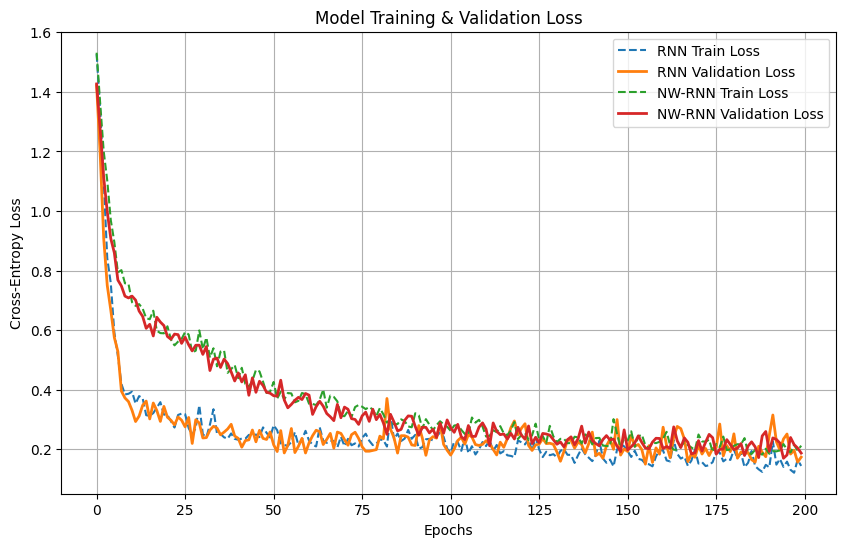

In [18]:
TRAIN_FILE_PATH = train_file_paths[0]
TEST_FILE_PATH = test_file_paths[0]
print(f"Running experiments for {names[0]} dataset")
train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes = run_experiment_rnn_models(TRAIN_FILE_PATH, TEST_FILE_PATH)


In [19]:
print(f"Running experiments for {names[0]} dataset")
run_experiment_esn_models(train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes)    

Running experiments for ECG5000 dataset
Carrying out Hyperparameter search for ESN and NW-ESN networks:
Running experiments on device: cuda

--- 1. Starting NW-ESN Grid Search (from Table 3a) ---
Total combinations to check: 360


NW-ESN Grid Search:   0%|          | 0/360 [00:00<?, ?it/s]

--- NW-ESN Search Complete ---
Best NW-ESN Val Acc: 88.00%
Best NW-ESN Params: {'w': 10.0, 'beta': 1.0, 'p': 0.95, 'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0, 'rescale_s': 1.5, 'gamma': 0.8, 'delta_t': 0.01}

--- 2. Starting ESN Grid Search (from Table 3c) ---
Total combinations to check: 72


ESN Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]

--- ESN Search Complete ---
Best ESN Val Acc: 88.00%
Best ESN Params: {'w': 1.0, 'beta': 0.001, 'p': 0.8, 'leaking_rate': 0.3}

--- 3. Final Evaluation on Test Set (using best models) ---


Testing NW-ESN:   0%|          | 0/71 [00:00<?, ?it/s]

  Model: NW-ESN
    -> Best Validation Accuracy: 88.00%
    -> Final Test Accuracy: 82.02%
    -> Best Params: {'w': 10.0, 'beta': 1.0, 'p': 0.95, 'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0, 'rescale_s': 1.5, 'gamma': 0.8, 'delta_t': 0.01}
------------------------------------------------------
--- Generating Final Model Comparison ---


Testing RNN:   0%|          | 0/71 [00:00<?, ?it/s]

Testing NW-RNN:   0%|          | 0/71 [00:00<?, ?it/s]

Testing NW-ESN:   0%|          | 0/71 [00:00<?, ?it/s]

Testing ESN:   0%|          | 0/71 [00:00<?, ?it/s]


--- Final Model Comparison Summary ---
Model           | Test Accuracy   | Total Params    | Trainable Params
---------------------------------------------------------------------------
ESN             | 83.78         % | 10,705          | 505            
NW-ESN (ours)   | 82.02         % | 10,705          | 505            
RNN             | 93.20         % | 10,805          | 10,805         
NW-RNN (ours)   | 92.78         % | 10,705          | 10,705         
--- Measuring Model Inference Time ---
Loaded full test set onto cuda (4500 samples)
Time for RNN: 19.65 ms
Time for NW-RNN (ours): 51.39 ms
Time for ESN: 24.51 ms
Time for NW-ESN (ours): 46.24 ms

--- Full Test Set Inference Time ---
Model           | Time (ms)      
----------------------------------------
ESN             | 24.51          ms
NW-ESN (ours)   | 46.24          ms
RNN             | 19.65          ms
NW-RNN (ours)   | 51.39          ms


### Synthetic control

Running experiments for Synthetic_Control dataset
Full train set: (300, 60)
Train set (80%): (240, 60)
Validation set (20%): (60, 60)
Test set: (300, 60)

Data ready for PyTorch:
Input size: 1
Output classes: 6

--- Training Standard RNN ---
Using device: cuda

Starting Standard RNN Classifier Training for 200 epochs...


Epoch 1/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/200 | Train Loss: 1.786133 | Val Loss: 1.767958 | Val Acc: 21.67%


Epoch 2/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/200 | Train Loss: 1.755386 | Val Loss: 1.737486 | Val Acc: 33.33%


Epoch 3/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/200 | Train Loss: 1.722443 | Val Loss: 1.698478 | Val Acc: 33.33%


Epoch 4/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/200 | Train Loss: 1.675296 | Val Loss: 1.632829 | Val Acc: 33.33%


Epoch 5/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/200 | Train Loss: 1.588024 | Val Loss: 1.491609 | Val Acc: 33.33%


Epoch 6/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/200 | Train Loss: 1.433752 | Val Loss: 1.424115 | Val Acc: 33.33%


Epoch 7/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/200 | Train Loss: 1.509883 | Val Loss: 1.470658 | Val Acc: 31.67%


Epoch 8/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/200 | Train Loss: 1.378242 | Val Loss: 1.305767 | Val Acc: 33.33%


Epoch 9/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/200 | Train Loss: 1.298090 | Val Loss: 1.303108 | Val Acc: 36.67%


Epoch 10/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/200 | Train Loss: 1.271915 | Val Loss: 1.249664 | Val Acc: 36.67%


Epoch 11/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/200 | Train Loss: 1.215555 | Val Loss: 1.217868 | Val Acc: 36.67%


Epoch 12/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/200 | Train Loss: 1.205213 | Val Loss: 1.202251 | Val Acc: 38.33%


Epoch 13/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/200 | Train Loss: 1.179667 | Val Loss: 1.185791 | Val Acc: 35.00%


Epoch 14/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/200 | Train Loss: 1.153812 | Val Loss: 1.198565 | Val Acc: 35.00%


Epoch 15/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/200 | Train Loss: 1.158788 | Val Loss: 1.170596 | Val Acc: 35.00%


Epoch 16/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/200 | Train Loss: 1.135704 | Val Loss: 1.141167 | Val Acc: 46.67%


Epoch 17/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/200 | Train Loss: 1.120092 | Val Loss: 1.128245 | Val Acc: 36.67%


Epoch 18/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/200 | Train Loss: 1.109700 | Val Loss: 1.123536 | Val Acc: 45.00%


Epoch 19/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/200 | Train Loss: 1.094686 | Val Loss: 1.108471 | Val Acc: 43.33%


Epoch 20/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/200 | Train Loss: 1.079253 | Val Loss: 1.080432 | Val Acc: 48.33%


Epoch 21/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/200 | Train Loss: 1.061573 | Val Loss: 1.074243 | Val Acc: 41.67%


Epoch 22/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/200 | Train Loss: 1.050030 | Val Loss: 1.066577 | Val Acc: 41.67%


Epoch 23/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/200 | Train Loss: 1.040253 | Val Loss: 1.045002 | Val Acc: 40.00%


Epoch 24/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/200 | Train Loss: 1.023959 | Val Loss: 1.014772 | Val Acc: 51.67%


Epoch 25/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/200 | Train Loss: 0.985635 | Val Loss: 1.004058 | Val Acc: 53.33%


Epoch 26/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/200 | Train Loss: 0.956716 | Val Loss: 0.969758 | Val Acc: 48.33%


Epoch 27/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/200 | Train Loss: 0.924575 | Val Loss: 0.927072 | Val Acc: 50.00%


Epoch 28/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/200 | Train Loss: 0.890311 | Val Loss: 0.885743 | Val Acc: 53.33%


Epoch 29/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/200 | Train Loss: 0.869501 | Val Loss: 0.864914 | Val Acc: 56.67%


Epoch 30/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/200 | Train Loss: 0.848142 | Val Loss: 0.873169 | Val Acc: 56.67%


Epoch 31/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/200 | Train Loss: 0.826628 | Val Loss: 0.820856 | Val Acc: 55.00%


Epoch 32/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/200 | Train Loss: 0.802831 | Val Loss: 0.795389 | Val Acc: 60.00%


Epoch 33/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/200 | Train Loss: 0.804245 | Val Loss: 0.813856 | Val Acc: 66.67%


Epoch 34/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/200 | Train Loss: 0.776920 | Val Loss: 0.777761 | Val Acc: 66.67%


Epoch 35/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/200 | Train Loss: 0.766125 | Val Loss: 0.792088 | Val Acc: 66.67%


Epoch 36/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/200 | Train Loss: 0.762997 | Val Loss: 0.746756 | Val Acc: 68.33%


Epoch 37/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/200 | Train Loss: 0.743580 | Val Loss: 0.738645 | Val Acc: 70.00%


Epoch 38/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/200 | Train Loss: 0.734682 | Val Loss: 0.723305 | Val Acc: 73.33%


Epoch 39/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/200 | Train Loss: 0.724194 | Val Loss: 0.719792 | Val Acc: 75.00%


Epoch 40/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/200 | Train Loss: 0.717767 | Val Loss: 0.889363 | Val Acc: 73.33%


Epoch 41/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/200 | Train Loss: 0.801620 | Val Loss: 0.704393 | Val Acc: 73.33%


Epoch 42/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/200 | Train Loss: 0.706151 | Val Loss: 0.705886 | Val Acc: 75.00%


Epoch 43/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/200 | Train Loss: 0.704282 | Val Loss: 0.702194 | Val Acc: 73.33%


Epoch 44/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/200 | Train Loss: 0.696274 | Val Loss: 0.693733 | Val Acc: 81.67%


Epoch 45/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/200 | Train Loss: 0.692545 | Val Loss: 0.687468 | Val Acc: 68.33%


Epoch 46/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/200 | Train Loss: 0.683455 | Val Loss: 0.682899 | Val Acc: 73.33%


Epoch 47/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/200 | Train Loss: 0.678739 | Val Loss: 0.700503 | Val Acc: 73.33%


Epoch 48/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/200 | Train Loss: 0.669158 | Val Loss: 0.716742 | Val Acc: 78.33%


Epoch 49/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/200 | Train Loss: 0.660367 | Val Loss: 0.692475 | Val Acc: 80.00%


Epoch 50/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/200 | Train Loss: 0.650512 | Val Loss: 0.698054 | Val Acc: 71.67%


Epoch 51/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/200 | Train Loss: 0.636052 | Val Loss: 0.649055 | Val Acc: 78.33%


Epoch 52/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/200 | Train Loss: 0.626840 | Val Loss: 0.633454 | Val Acc: 76.67%


Epoch 53/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/200 | Train Loss: 0.618437 | Val Loss: 0.712563 | Val Acc: 70.00%


Epoch 54/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/200 | Train Loss: 0.627859 | Val Loss: 0.618390 | Val Acc: 75.00%


Epoch 55/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/200 | Train Loss: 0.606972 | Val Loss: 0.656999 | Val Acc: 66.67%


Epoch 56/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/200 | Train Loss: 0.587897 | Val Loss: 0.658824 | Val Acc: 71.67%


Epoch 57/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/200 | Train Loss: 0.571807 | Val Loss: 0.651105 | Val Acc: 73.33%


Epoch 58/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/200 | Train Loss: 0.570204 | Val Loss: 0.611059 | Val Acc: 75.00%


Epoch 59/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/200 | Train Loss: 0.560741 | Val Loss: 0.679172 | Val Acc: 68.33%


Epoch 60/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/200 | Train Loss: 0.555723 | Val Loss: 0.584369 | Val Acc: 75.00%


Epoch 61/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/200 | Train Loss: 0.543010 | Val Loss: 0.667901 | Val Acc: 76.67%


Epoch 62/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/200 | Train Loss: 0.540585 | Val Loss: 0.578822 | Val Acc: 71.67%


Epoch 63/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/200 | Train Loss: 0.548299 | Val Loss: 0.605143 | Val Acc: 76.67%


Epoch 64/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/200 | Train Loss: 0.565384 | Val Loss: 0.625225 | Val Acc: 70.00%


Epoch 65/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/200 | Train Loss: 0.524400 | Val Loss: 0.566246 | Val Acc: 75.00%


Epoch 66/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/200 | Train Loss: 0.511997 | Val Loss: 0.612758 | Val Acc: 71.67%


Epoch 67/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/200 | Train Loss: 0.495899 | Val Loss: 0.554495 | Val Acc: 73.33%


Epoch 68/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/200 | Train Loss: 0.495962 | Val Loss: 0.601442 | Val Acc: 71.67%


Epoch 69/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/200 | Train Loss: 0.492722 | Val Loss: 0.548851 | Val Acc: 76.67%


Epoch 70/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/200 | Train Loss: 0.481091 | Val Loss: 0.575034 | Val Acc: 73.33%


Epoch 71/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/200 | Train Loss: 0.490003 | Val Loss: 0.586029 | Val Acc: 70.00%


Epoch 72/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/200 | Train Loss: 0.474323 | Val Loss: 0.537008 | Val Acc: 73.33%


Epoch 73/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/200 | Train Loss: 0.464776 | Val Loss: 0.527285 | Val Acc: 78.33%


Epoch 74/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/200 | Train Loss: 0.468518 | Val Loss: 0.566584 | Val Acc: 76.67%


Epoch 75/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/200 | Train Loss: 0.455780 | Val Loss: 0.524592 | Val Acc: 75.00%


Epoch 76/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/200 | Train Loss: 0.454025 | Val Loss: 0.520045 | Val Acc: 73.33%


Epoch 77/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/200 | Train Loss: 0.447306 | Val Loss: 0.497362 | Val Acc: 76.67%


Epoch 78/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/200 | Train Loss: 0.446327 | Val Loss: 0.554821 | Val Acc: 76.67%


Epoch 79/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/200 | Train Loss: 0.435472 | Val Loss: 0.495498 | Val Acc: 78.33%


Epoch 80/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/200 | Train Loss: 0.435994 | Val Loss: 0.492157 | Val Acc: 76.67%


Epoch 81/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/200 | Train Loss: 0.430478 | Val Loss: 0.494334 | Val Acc: 80.00%


Epoch 82/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/200 | Train Loss: 0.418513 | Val Loss: 0.490931 | Val Acc: 75.00%


Epoch 83/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/200 | Train Loss: 0.410664 | Val Loss: 0.479324 | Val Acc: 78.33%


Epoch 84/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/200 | Train Loss: 0.416166 | Val Loss: 0.487718 | Val Acc: 85.00%


Epoch 85/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/200 | Train Loss: 0.412868 | Val Loss: 0.455792 | Val Acc: 80.00%


Epoch 86/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/200 | Train Loss: 0.403638 | Val Loss: 0.477657 | Val Acc: 81.67%


Epoch 87/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/200 | Train Loss: 0.395434 | Val Loss: 0.462438 | Val Acc: 80.00%


Epoch 88/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/200 | Train Loss: 0.393071 | Val Loss: 0.494241 | Val Acc: 80.00%


Epoch 89/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/200 | Train Loss: 0.379539 | Val Loss: 0.460313 | Val Acc: 81.67%


Epoch 90/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/200 | Train Loss: 0.381308 | Val Loss: 0.436168 | Val Acc: 85.00%


Epoch 91/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/200 | Train Loss: 0.367616 | Val Loss: 0.495941 | Val Acc: 78.33%


Epoch 92/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/200 | Train Loss: 0.373708 | Val Loss: 0.457551 | Val Acc: 83.33%


Epoch 93/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/200 | Train Loss: 0.362297 | Val Loss: 0.456900 | Val Acc: 81.67%


Epoch 94/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/200 | Train Loss: 0.352983 | Val Loss: 0.425299 | Val Acc: 83.33%


Epoch 95/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/200 | Train Loss: 0.353785 | Val Loss: 0.437447 | Val Acc: 85.00%


Epoch 96/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/200 | Train Loss: 0.365308 | Val Loss: 0.453859 | Val Acc: 81.67%


Epoch 97/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/200 | Train Loss: 0.345154 | Val Loss: 0.435111 | Val Acc: 85.00%


Epoch 98/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/200 | Train Loss: 0.370240 | Val Loss: 0.461257 | Val Acc: 83.33%


Epoch 99/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/200 | Train Loss: 0.348711 | Val Loss: 0.494487 | Val Acc: 86.67%


Epoch 100/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/200 | Train Loss: 0.350519 | Val Loss: 0.427414 | Val Acc: 88.33%


Epoch 101/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/200 | Train Loss: 0.329414 | Val Loss: 0.386171 | Val Acc: 83.33%


Epoch 102/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/200 | Train Loss: 0.319784 | Val Loss: 0.367801 | Val Acc: 88.33%


Epoch 103/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/200 | Train Loss: 0.320313 | Val Loss: 0.368978 | Val Acc: 85.00%


Epoch 104/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/200 | Train Loss: 0.332027 | Val Loss: 0.335729 | Val Acc: 88.33%


Epoch 105/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/200 | Train Loss: 0.327779 | Val Loss: 0.346048 | Val Acc: 86.67%


Epoch 106/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/200 | Train Loss: 0.302938 | Val Loss: 0.323832 | Val Acc: 90.00%


Epoch 107/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/200 | Train Loss: 0.308632 | Val Loss: 0.339644 | Val Acc: 83.33%


Epoch 108/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/200 | Train Loss: 0.329937 | Val Loss: 0.366069 | Val Acc: 86.67%


Epoch 109/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/200 | Train Loss: 0.331728 | Val Loss: 0.349551 | Val Acc: 86.67%


Epoch 110/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/200 | Train Loss: 0.307054 | Val Loss: 0.341206 | Val Acc: 81.67%


Epoch 111/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/200 | Train Loss: 0.323741 | Val Loss: 0.295395 | Val Acc: 95.00%


Epoch 112/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/200 | Train Loss: 0.289978 | Val Loss: 0.390590 | Val Acc: 85.00%


Epoch 113/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/200 | Train Loss: 0.353148 | Val Loss: 0.350100 | Val Acc: 86.67%


Epoch 114/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/200 | Train Loss: 0.274753 | Val Loss: 0.384932 | Val Acc: 85.00%


Epoch 115/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/200 | Train Loss: 0.284538 | Val Loss: 0.302870 | Val Acc: 91.67%


Epoch 116/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/200 | Train Loss: 0.299230 | Val Loss: 0.306905 | Val Acc: 91.67%


Epoch 117/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/200 | Train Loss: 0.295250 | Val Loss: 0.292120 | Val Acc: 88.33%


Epoch 118/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/200 | Train Loss: 0.252741 | Val Loss: 0.274544 | Val Acc: 91.67%


Epoch 119/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/200 | Train Loss: 0.255360 | Val Loss: 0.272749 | Val Acc: 88.33%


Epoch 120/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/200 | Train Loss: 0.341351 | Val Loss: 0.341858 | Val Acc: 86.67%


Epoch 121/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/200 | Train Loss: 0.261381 | Val Loss: 0.314956 | Val Acc: 90.00%


Epoch 122/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/200 | Train Loss: 0.290197 | Val Loss: 0.366344 | Val Acc: 90.00%


Epoch 123/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/200 | Train Loss: 0.273034 | Val Loss: 0.331690 | Val Acc: 86.67%


Epoch 124/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/200 | Train Loss: 0.254850 | Val Loss: 0.284502 | Val Acc: 88.33%


Epoch 125/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/200 | Train Loss: 0.237722 | Val Loss: 0.303738 | Val Acc: 91.67%


Epoch 126/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/200 | Train Loss: 0.243260 | Val Loss: 0.254689 | Val Acc: 95.00%


Epoch 127/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/200 | Train Loss: 0.231104 | Val Loss: 0.262675 | Val Acc: 93.33%


Epoch 128/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/200 | Train Loss: 0.232403 | Val Loss: 0.256228 | Val Acc: 90.00%


Epoch 129/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/200 | Train Loss: 0.214804 | Val Loss: 0.276130 | Val Acc: 91.67%


Epoch 130/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/200 | Train Loss: 0.213052 | Val Loss: 0.321016 | Val Acc: 93.33%


Epoch 131/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/200 | Train Loss: 0.219794 | Val Loss: 0.283230 | Val Acc: 90.00%


Epoch 132/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/200 | Train Loss: 0.199261 | Val Loss: 0.254297 | Val Acc: 95.00%


Epoch 133/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/200 | Train Loss: 0.194335 | Val Loss: 0.275123 | Val Acc: 91.67%


Epoch 134/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/200 | Train Loss: 0.215078 | Val Loss: 0.236312 | Val Acc: 93.33%


Epoch 135/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/200 | Train Loss: 0.238174 | Val Loss: 0.257117 | Val Acc: 93.33%


Epoch 136/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/200 | Train Loss: 0.211219 | Val Loss: 0.245697 | Val Acc: 93.33%


Epoch 137/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/200 | Train Loss: 0.244251 | Val Loss: 0.314261 | Val Acc: 88.33%


Epoch 138/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/200 | Train Loss: 0.202480 | Val Loss: 0.245436 | Val Acc: 95.00%


Epoch 139/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/200 | Train Loss: 0.203582 | Val Loss: 0.236371 | Val Acc: 95.00%


Epoch 140/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/200 | Train Loss: 0.182036 | Val Loss: 0.277316 | Val Acc: 90.00%


Epoch 141/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/200 | Train Loss: 0.224842 | Val Loss: 0.255149 | Val Acc: 91.67%


Epoch 142/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/200 | Train Loss: 0.168691 | Val Loss: 0.218937 | Val Acc: 95.00%


Epoch 143/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/200 | Train Loss: 0.203752 | Val Loss: 0.235637 | Val Acc: 95.00%


Epoch 144/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/200 | Train Loss: 0.158104 | Val Loss: 0.231148 | Val Acc: 93.33%


Epoch 145/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/200 | Train Loss: 0.157495 | Val Loss: 0.263160 | Val Acc: 93.33%


Epoch 146/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/200 | Train Loss: 0.215384 | Val Loss: 0.269827 | Val Acc: 93.33%


Epoch 147/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/200 | Train Loss: 0.193554 | Val Loss: 0.255484 | Val Acc: 93.33%


Epoch 148/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/200 | Train Loss: 0.161483 | Val Loss: 0.191005 | Val Acc: 98.33%


Epoch 149/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/200 | Train Loss: 0.156239 | Val Loss: 0.268482 | Val Acc: 90.00%


Epoch 150/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/200 | Train Loss: 0.233386 | Val Loss: 0.245692 | Val Acc: 91.67%


Epoch 151/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/200 | Train Loss: 0.197641 | Val Loss: 0.225492 | Val Acc: 95.00%


Epoch 152/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/200 | Train Loss: 0.282801 | Val Loss: 0.255650 | Val Acc: 91.67%


Epoch 153/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/200 | Train Loss: 0.185316 | Val Loss: 0.223438 | Val Acc: 93.33%


Epoch 154/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/200 | Train Loss: 0.143933 | Val Loss: 0.227479 | Val Acc: 93.33%


Epoch 155/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/200 | Train Loss: 0.159499 | Val Loss: 0.218139 | Val Acc: 96.67%


Epoch 156/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/200 | Train Loss: 0.165462 | Val Loss: 0.217040 | Val Acc: 95.00%


Epoch 157/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/200 | Train Loss: 0.129297 | Val Loss: 0.226918 | Val Acc: 93.33%


Epoch 158/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/200 | Train Loss: 0.137618 | Val Loss: 0.166884 | Val Acc: 96.67%


Epoch 159/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/200 | Train Loss: 0.136050 | Val Loss: 0.209433 | Val Acc: 93.33%


Epoch 160/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/200 | Train Loss: 0.131979 | Val Loss: 0.198349 | Val Acc: 95.00%


Epoch 161/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161/200 | Train Loss: 0.161424 | Val Loss: 0.239334 | Val Acc: 93.33%


Epoch 162/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/200 | Train Loss: 0.134724 | Val Loss: 0.288255 | Val Acc: 88.33%


Epoch 163/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/200 | Train Loss: 0.161700 | Val Loss: 0.162011 | Val Acc: 95.00%


Epoch 164/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/200 | Train Loss: 0.131454 | Val Loss: 0.180761 | Val Acc: 95.00%


Epoch 165/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/200 | Train Loss: 0.147702 | Val Loss: 0.230636 | Val Acc: 93.33%


Epoch 166/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 166/200 | Train Loss: 0.186443 | Val Loss: 0.221085 | Val Acc: 95.00%


Epoch 167/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/200 | Train Loss: 0.244610 | Val Loss: 0.212798 | Val Acc: 93.33%


Epoch 168/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/200 | Train Loss: 0.144722 | Val Loss: 0.197208 | Val Acc: 95.00%


Epoch 169/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/200 | Train Loss: 0.151781 | Val Loss: 0.186833 | Val Acc: 93.33%


Epoch 170/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/200 | Train Loss: 0.305466 | Val Loss: 0.433268 | Val Acc: 90.00%


Epoch 171/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 171/200 | Train Loss: 0.215025 | Val Loss: 0.181769 | Val Acc: 95.00%


Epoch 172/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/200 | Train Loss: 0.165555 | Val Loss: 0.197805 | Val Acc: 95.00%


Epoch 173/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/200 | Train Loss: 0.116804 | Val Loss: 0.167954 | Val Acc: 96.67%


Epoch 174/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/200 | Train Loss: 0.147999 | Val Loss: 0.216506 | Val Acc: 93.33%


Epoch 175/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/200 | Train Loss: 0.124015 | Val Loss: 0.211485 | Val Acc: 95.00%


Epoch 176/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 176/200 | Train Loss: 0.123897 | Val Loss: 0.208124 | Val Acc: 95.00%


Epoch 177/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/200 | Train Loss: 0.138710 | Val Loss: 0.204410 | Val Acc: 95.00%


Epoch 178/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/200 | Train Loss: 0.107174 | Val Loss: 0.252855 | Val Acc: 93.33%


Epoch 179/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/200 | Train Loss: 0.134836 | Val Loss: 0.161889 | Val Acc: 96.67%


Epoch 180/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/200 | Train Loss: 0.174647 | Val Loss: 0.381688 | Val Acc: 86.67%


Epoch 181/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181/200 | Train Loss: 0.176905 | Val Loss: 0.199337 | Val Acc: 95.00%


Epoch 182/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/200 | Train Loss: 0.212962 | Val Loss: 0.213290 | Val Acc: 93.33%


Epoch 183/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/200 | Train Loss: 0.113403 | Val Loss: 0.188204 | Val Acc: 93.33%


Epoch 184/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/200 | Train Loss: 0.143619 | Val Loss: 0.252958 | Val Acc: 90.00%


Epoch 185/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/200 | Train Loss: 0.105950 | Val Loss: 0.188248 | Val Acc: 95.00%


Epoch 186/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 186/200 | Train Loss: 0.116199 | Val Loss: 0.234233 | Val Acc: 95.00%


Epoch 187/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/200 | Train Loss: 0.093357 | Val Loss: 0.185246 | Val Acc: 95.00%


Epoch 188/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/200 | Train Loss: 0.110499 | Val Loss: 0.163680 | Val Acc: 95.00%


Epoch 189/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/200 | Train Loss: 0.085595 | Val Loss: 0.184668 | Val Acc: 95.00%


Epoch 190/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/200 | Train Loss: 0.112337 | Val Loss: 0.276910 | Val Acc: 91.67%


Epoch 191/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 191/200 | Train Loss: 0.173450 | Val Loss: 0.234639 | Val Acc: 93.33%


Epoch 192/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/200 | Train Loss: 0.106102 | Val Loss: 0.196414 | Val Acc: 95.00%


Epoch 193/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/200 | Train Loss: 0.126869 | Val Loss: 0.272163 | Val Acc: 93.33%


Epoch 194/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/200 | Train Loss: 0.122830 | Val Loss: 0.281007 | Val Acc: 93.33%


Epoch 195/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/200 | Train Loss: 0.131346 | Val Loss: 0.111898 | Val Acc: 98.33%


Epoch 196/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 196/200 | Train Loss: 0.104167 | Val Loss: 0.177259 | Val Acc: 96.67%


Epoch 197/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/200 | Train Loss: 0.086627 | Val Loss: 0.157543 | Val Acc: 96.67%


Epoch 198/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/200 | Train Loss: 0.081930 | Val Loss: 0.175548 | Val Acc: 93.33%


Epoch 199/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/200 | Train Loss: 0.081505 | Val Loss: 0.325063 | Val Acc: 90.00%


Epoch 200/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/200 | Train Loss: 0.102210 | Val Loss: 0.230320 | Val Acc: 95.00%
Training complete.


Evaluating RNN:   0%|          | 0/5 [00:00<?, ?it/s]

Standard RNN Test Accuracy: 96.33%

--- Training NW-RNN model ---
Using device: cuda

Starting NW-RNN Classifier Training for 200 epochs...


Epoch 1/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/200 | Train Loss: 1.784050 | Val Loss: 1.768246 | Val Acc: 23.33%


Epoch 2/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/200 | Train Loss: 1.759076 | Val Loss: 1.744385 | Val Acc: 46.67%


Epoch 3/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/200 | Train Loss: 1.733679 | Val Loss: 1.721595 | Val Acc: 45.00%


Epoch 4/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/200 | Train Loss: 1.710679 | Val Loss: 1.699890 | Val Acc: 48.33%


Epoch 5/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/200 | Train Loss: 1.692150 | Val Loss: 1.679245 | Val Acc: 48.33%


Epoch 6/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/200 | Train Loss: 1.670445 | Val Loss: 1.658942 | Val Acc: 50.00%


Epoch 7/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/200 | Train Loss: 1.649685 | Val Loss: 1.639105 | Val Acc: 50.00%


Epoch 8/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/200 | Train Loss: 1.630836 | Val Loss: 1.619318 | Val Acc: 50.00%


Epoch 9/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/200 | Train Loss: 1.610564 | Val Loss: 1.599505 | Val Acc: 51.67%


Epoch 10/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/200 | Train Loss: 1.589524 | Val Loss: 1.579175 | Val Acc: 55.00%


Epoch 11/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/200 | Train Loss: 1.570855 | Val Loss: 1.558275 | Val Acc: 58.33%


Epoch 12/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/200 | Train Loss: 1.551107 | Val Loss: 1.536901 | Val Acc: 58.33%


Epoch 13/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/200 | Train Loss: 1.529514 | Val Loss: 1.515096 | Val Acc: 53.33%


Epoch 14/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/200 | Train Loss: 1.505333 | Val Loss: 1.492995 | Val Acc: 56.67%


Epoch 15/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/200 | Train Loss: 1.481835 | Val Loss: 1.470121 | Val Acc: 51.67%


Epoch 16/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/200 | Train Loss: 1.461955 | Val Loss: 1.447001 | Val Acc: 50.00%


Epoch 17/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/200 | Train Loss: 1.437474 | Val Loss: 1.423776 | Val Acc: 55.00%


Epoch 18/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/200 | Train Loss: 1.414729 | Val Loss: 1.400056 | Val Acc: 50.00%


Epoch 19/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/200 | Train Loss: 1.384899 | Val Loss: 1.375983 | Val Acc: 50.00%


Epoch 20/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/200 | Train Loss: 1.365083 | Val Loss: 1.351986 | Val Acc: 58.33%


Epoch 21/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/200 | Train Loss: 1.340463 | Val Loss: 1.328361 | Val Acc: 56.67%


Epoch 22/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/200 | Train Loss: 1.317792 | Val Loss: 1.305279 | Val Acc: 60.00%


Epoch 23/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/200 | Train Loss: 1.294691 | Val Loss: 1.282654 | Val Acc: 68.33%


Epoch 24/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/200 | Train Loss: 1.272600 | Val Loss: 1.260515 | Val Acc: 55.00%


Epoch 25/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/200 | Train Loss: 1.251428 | Val Loss: 1.239836 | Val Acc: 50.00%


Epoch 26/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/200 | Train Loss: 1.231994 | Val Loss: 1.219772 | Val Acc: 51.67%


Epoch 27/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/200 | Train Loss: 1.210825 | Val Loss: 1.200340 | Val Acc: 58.33%


Epoch 28/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/200 | Train Loss: 1.191552 | Val Loss: 1.182018 | Val Acc: 58.33%


Epoch 29/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/200 | Train Loss: 1.173401 | Val Loss: 1.164634 | Val Acc: 58.33%


Epoch 30/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/200 | Train Loss: 1.157396 | Val Loss: 1.147163 | Val Acc: 53.33%


Epoch 31/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/200 | Train Loss: 1.136623 | Val Loss: 1.130217 | Val Acc: 58.33%


Epoch 32/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/200 | Train Loss: 1.122713 | Val Loss: 1.113990 | Val Acc: 63.33%


Epoch 33/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/200 | Train Loss: 1.104294 | Val Loss: 1.098326 | Val Acc: 65.00%


Epoch 34/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/200 | Train Loss: 1.089795 | Val Loss: 1.083359 | Val Acc: 65.00%


Epoch 35/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/200 | Train Loss: 1.076455 | Val Loss: 1.069486 | Val Acc: 63.33%


Epoch 36/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/200 | Train Loss: 1.062071 | Val Loss: 1.054839 | Val Acc: 66.67%


Epoch 37/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/200 | Train Loss: 1.046531 | Val Loss: 1.041080 | Val Acc: 66.67%


Epoch 38/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/200 | Train Loss: 1.033823 | Val Loss: 1.027936 | Val Acc: 68.33%


Epoch 39/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/200 | Train Loss: 1.022833 | Val Loss: 1.015208 | Val Acc: 68.33%


Epoch 40/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/200 | Train Loss: 1.008185 | Val Loss: 1.002153 | Val Acc: 70.00%


Epoch 41/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/200 | Train Loss: 0.993243 | Val Loss: 0.989803 | Val Acc: 75.00%


Epoch 42/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/200 | Train Loss: 0.982665 | Val Loss: 0.977661 | Val Acc: 76.67%


Epoch 43/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/200 | Train Loss: 0.972597 | Val Loss: 0.965744 | Val Acc: 75.00%


Epoch 44/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/200 | Train Loss: 0.958686 | Val Loss: 0.953794 | Val Acc: 73.33%


Epoch 45/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/200 | Train Loss: 0.948093 | Val Loss: 0.941960 | Val Acc: 73.33%


Epoch 46/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/200 | Train Loss: 0.934714 | Val Loss: 0.930561 | Val Acc: 78.33%


Epoch 47/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/200 | Train Loss: 0.925128 | Val Loss: 0.919110 | Val Acc: 76.67%


Epoch 48/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/200 | Train Loss: 0.913061 | Val Loss: 0.907664 | Val Acc: 73.33%


Epoch 49/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/200 | Train Loss: 0.902145 | Val Loss: 0.896787 | Val Acc: 73.33%


Epoch 50/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/200 | Train Loss: 0.892122 | Val Loss: 0.885756 | Val Acc: 75.00%


Epoch 51/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/200 | Train Loss: 0.880701 | Val Loss: 0.875117 | Val Acc: 78.33%


Epoch 52/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/200 | Train Loss: 0.871608 | Val Loss: 0.864882 | Val Acc: 78.33%


Epoch 53/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/200 | Train Loss: 0.859369 | Val Loss: 0.854757 | Val Acc: 78.33%


Epoch 54/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/200 | Train Loss: 0.851783 | Val Loss: 0.845165 | Val Acc: 76.67%


Epoch 55/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/200 | Train Loss: 0.841630 | Val Loss: 0.835380 | Val Acc: 76.67%


Epoch 56/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/200 | Train Loss: 0.832692 | Val Loss: 0.825771 | Val Acc: 76.67%


Epoch 57/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/200 | Train Loss: 0.823409 | Val Loss: 0.816530 | Val Acc: 76.67%


Epoch 58/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/200 | Train Loss: 0.815191 | Val Loss: 0.807601 | Val Acc: 75.00%


Epoch 59/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/200 | Train Loss: 0.806152 | Val Loss: 0.798519 | Val Acc: 75.00%


Epoch 60/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/200 | Train Loss: 0.796119 | Val Loss: 0.790068 | Val Acc: 78.33%


Epoch 61/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/200 | Train Loss: 0.788653 | Val Loss: 0.781693 | Val Acc: 80.00%


Epoch 62/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/200 | Train Loss: 0.781682 | Val Loss: 0.773351 | Val Acc: 80.00%


Epoch 63/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/200 | Train Loss: 0.772463 | Val Loss: 0.764972 | Val Acc: 76.67%


Epoch 64/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/200 | Train Loss: 0.765310 | Val Loss: 0.756560 | Val Acc: 76.67%


Epoch 65/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/200 | Train Loss: 0.758748 | Val Loss: 0.748527 | Val Acc: 80.00%


Epoch 66/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/200 | Train Loss: 0.750792 | Val Loss: 0.740548 | Val Acc: 76.67%


Epoch 67/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/200 | Train Loss: 0.741693 | Val Loss: 0.732518 | Val Acc: 78.33%


Epoch 68/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/200 | Train Loss: 0.734154 | Val Loss: 0.724966 | Val Acc: 78.33%


Epoch 69/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/200 | Train Loss: 0.725508 | Val Loss: 0.717290 | Val Acc: 78.33%


Epoch 70/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/200 | Train Loss: 0.720065 | Val Loss: 0.709721 | Val Acc: 80.00%


Epoch 71/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/200 | Train Loss: 0.712958 | Val Loss: 0.702191 | Val Acc: 80.00%


Epoch 72/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/200 | Train Loss: 0.704916 | Val Loss: 0.694510 | Val Acc: 80.00%


Epoch 73/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/200 | Train Loss: 0.695953 | Val Loss: 0.687486 | Val Acc: 81.67%


Epoch 74/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/200 | Train Loss: 0.689039 | Val Loss: 0.680669 | Val Acc: 83.33%


Epoch 75/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/200 | Train Loss: 0.682863 | Val Loss: 0.673571 | Val Acc: 81.67%


Epoch 76/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/200 | Train Loss: 0.672573 | Val Loss: 0.666900 | Val Acc: 81.67%


Epoch 77/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/200 | Train Loss: 0.666582 | Val Loss: 0.659715 | Val Acc: 81.67%


Epoch 78/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/200 | Train Loss: 0.658835 | Val Loss: 0.652747 | Val Acc: 81.67%


Epoch 79/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/200 | Train Loss: 0.652840 | Val Loss: 0.646199 | Val Acc: 83.33%


Epoch 80/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/200 | Train Loss: 0.642161 | Val Loss: 0.640723 | Val Acc: 83.33%


Epoch 81/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/200 | Train Loss: 0.636388 | Val Loss: 0.631528 | Val Acc: 85.00%


Epoch 82/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/200 | Train Loss: 0.631326 | Val Loss: 0.625313 | Val Acc: 83.33%


Epoch 83/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/200 | Train Loss: 0.626028 | Val Loss: 0.630874 | Val Acc: 81.67%


Epoch 84/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/200 | Train Loss: 0.613725 | Val Loss: 0.616281 | Val Acc: 81.67%


Epoch 85/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/200 | Train Loss: 0.604856 | Val Loss: 0.606597 | Val Acc: 81.67%


Epoch 86/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/200 | Train Loss: 0.595100 | Val Loss: 0.597349 | Val Acc: 85.00%


Epoch 87/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/200 | Train Loss: 0.586960 | Val Loss: 0.591093 | Val Acc: 83.33%


Epoch 88/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/200 | Train Loss: 0.580913 | Val Loss: 0.585796 | Val Acc: 81.67%


Epoch 89/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/200 | Train Loss: 0.573020 | Val Loss: 0.575280 | Val Acc: 83.33%


Epoch 90/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/200 | Train Loss: 0.566480 | Val Loss: 0.568255 | Val Acc: 85.00%


Epoch 91/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/200 | Train Loss: 0.556038 | Val Loss: 0.560394 | Val Acc: 83.33%


Epoch 92/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/200 | Train Loss: 0.548266 | Val Loss: 0.555014 | Val Acc: 83.33%


Epoch 93/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/200 | Train Loss: 0.543273 | Val Loss: 0.549866 | Val Acc: 81.67%


Epoch 94/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/200 | Train Loss: 0.537799 | Val Loss: 0.543982 | Val Acc: 85.00%


Epoch 95/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/200 | Train Loss: 0.526826 | Val Loss: 0.535163 | Val Acc: 83.33%


Epoch 96/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/200 | Train Loss: 0.524554 | Val Loss: 0.527343 | Val Acc: 85.00%


Epoch 97/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/200 | Train Loss: 0.513159 | Val Loss: 0.518329 | Val Acc: 85.00%


Epoch 98/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/200 | Train Loss: 0.502815 | Val Loss: 0.511791 | Val Acc: 85.00%


Epoch 99/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/200 | Train Loss: 0.498577 | Val Loss: 0.505943 | Val Acc: 88.33%


Epoch 100/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/200 | Train Loss: 0.492748 | Val Loss: 0.503099 | Val Acc: 86.67%


Epoch 101/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/200 | Train Loss: 0.482369 | Val Loss: 0.495333 | Val Acc: 88.33%


Epoch 102/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/200 | Train Loss: 0.486416 | Val Loss: 0.489073 | Val Acc: 86.67%


Epoch 103/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/200 | Train Loss: 0.477119 | Val Loss: 0.488670 | Val Acc: 85.00%


Epoch 104/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/200 | Train Loss: 0.468003 | Val Loss: 0.480412 | Val Acc: 85.00%


Epoch 105/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/200 | Train Loss: 0.467957 | Val Loss: 0.471845 | Val Acc: 86.67%


Epoch 106/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/200 | Train Loss: 0.455280 | Val Loss: 0.466315 | Val Acc: 88.33%


Epoch 107/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/200 | Train Loss: 0.450477 | Val Loss: 0.460862 | Val Acc: 90.00%


Epoch 108/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/200 | Train Loss: 0.444139 | Val Loss: 0.455624 | Val Acc: 88.33%


Epoch 109/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/200 | Train Loss: 0.440014 | Val Loss: 0.451325 | Val Acc: 85.00%


Epoch 110/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/200 | Train Loss: 0.438892 | Val Loss: 0.448075 | Val Acc: 88.33%


Epoch 111/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/200 | Train Loss: 0.432677 | Val Loss: 0.445890 | Val Acc: 88.33%


Epoch 112/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/200 | Train Loss: 0.427423 | Val Loss: 0.443382 | Val Acc: 86.67%


Epoch 113/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/200 | Train Loss: 0.425269 | Val Loss: 0.437899 | Val Acc: 86.67%


Epoch 114/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/200 | Train Loss: 0.412511 | Val Loss: 0.433956 | Val Acc: 90.00%


Epoch 115/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/200 | Train Loss: 0.410909 | Val Loss: 0.432316 | Val Acc: 86.67%


Epoch 116/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/200 | Train Loss: 0.409520 | Val Loss: 0.426217 | Val Acc: 90.00%


Epoch 117/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/200 | Train Loss: 0.403183 | Val Loss: 0.424935 | Val Acc: 88.33%


Epoch 118/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/200 | Train Loss: 0.397004 | Val Loss: 0.418478 | Val Acc: 88.33%


Epoch 119/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/200 | Train Loss: 0.396057 | Val Loss: 0.415235 | Val Acc: 90.00%


Epoch 120/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/200 | Train Loss: 0.394650 | Val Loss: 0.413220 | Val Acc: 86.67%


Epoch 121/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/200 | Train Loss: 0.398717 | Val Loss: 0.410643 | Val Acc: 88.33%


Epoch 122/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/200 | Train Loss: 0.390726 | Val Loss: 0.410294 | Val Acc: 88.33%


Epoch 123/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/200 | Train Loss: 0.382135 | Val Loss: 0.408159 | Val Acc: 90.00%


Epoch 124/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/200 | Train Loss: 0.376180 | Val Loss: 0.405825 | Val Acc: 88.33%


Epoch 125/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/200 | Train Loss: 0.378322 | Val Loss: 0.403271 | Val Acc: 88.33%


Epoch 126/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/200 | Train Loss: 0.370972 | Val Loss: 0.402388 | Val Acc: 90.00%


Epoch 127/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/200 | Train Loss: 0.369082 | Val Loss: 0.401164 | Val Acc: 90.00%


Epoch 128/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/200 | Train Loss: 0.367321 | Val Loss: 0.396203 | Val Acc: 90.00%


Epoch 129/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/200 | Train Loss: 0.364803 | Val Loss: 0.393445 | Val Acc: 88.33%


Epoch 130/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/200 | Train Loss: 0.359823 | Val Loss: 0.391807 | Val Acc: 90.00%


Epoch 131/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/200 | Train Loss: 0.357887 | Val Loss: 0.390239 | Val Acc: 88.33%


Epoch 132/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/200 | Train Loss: 0.357015 | Val Loss: 0.388280 | Val Acc: 88.33%


Epoch 133/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/200 | Train Loss: 0.348391 | Val Loss: 0.388152 | Val Acc: 88.33%


Epoch 134/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/200 | Train Loss: 0.344786 | Val Loss: 0.385725 | Val Acc: 90.00%


Epoch 135/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/200 | Train Loss: 0.343492 | Val Loss: 0.385079 | Val Acc: 90.00%


Epoch 136/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/200 | Train Loss: 0.346379 | Val Loss: 0.384344 | Val Acc: 88.33%


Epoch 137/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/200 | Train Loss: 0.338943 | Val Loss: 0.383293 | Val Acc: 90.00%


Epoch 138/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/200 | Train Loss: 0.337746 | Val Loss: 0.383534 | Val Acc: 90.00%


Epoch 139/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/200 | Train Loss: 0.332819 | Val Loss: 0.380978 | Val Acc: 90.00%


Epoch 140/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/200 | Train Loss: 0.330571 | Val Loss: 0.378981 | Val Acc: 90.00%


Epoch 141/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/200 | Train Loss: 0.332405 | Val Loss: 0.378487 | Val Acc: 90.00%


Epoch 142/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/200 | Train Loss: 0.334551 | Val Loss: 0.376107 | Val Acc: 88.33%


Epoch 143/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/200 | Train Loss: 0.330672 | Val Loss: 0.378007 | Val Acc: 90.00%


Epoch 144/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/200 | Train Loss: 0.325641 | Val Loss: 0.374997 | Val Acc: 90.00%


Epoch 145/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/200 | Train Loss: 0.323029 | Val Loss: 0.372588 | Val Acc: 90.00%


Epoch 146/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/200 | Train Loss: 0.322025 | Val Loss: 0.377901 | Val Acc: 90.00%


Epoch 147/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/200 | Train Loss: 0.317308 | Val Loss: 0.373155 | Val Acc: 90.00%


Epoch 148/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/200 | Train Loss: 0.318653 | Val Loss: 0.370841 | Val Acc: 90.00%


Epoch 149/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/200 | Train Loss: 0.313606 | Val Loss: 0.369911 | Val Acc: 88.33%


Epoch 150/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/200 | Train Loss: 0.310846 | Val Loss: 0.371568 | Val Acc: 90.00%


Epoch 151/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/200 | Train Loss: 0.311069 | Val Loss: 0.369689 | Val Acc: 90.00%


Epoch 152/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/200 | Train Loss: 0.312521 | Val Loss: 0.367099 | Val Acc: 91.67%


Epoch 153/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/200 | Train Loss: 0.304681 | Val Loss: 0.369927 | Val Acc: 90.00%


Epoch 154/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/200 | Train Loss: 0.305584 | Val Loss: 0.365950 | Val Acc: 90.00%


Epoch 155/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/200 | Train Loss: 0.301257 | Val Loss: 0.365964 | Val Acc: 91.67%


Epoch 156/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/200 | Train Loss: 0.300328 | Val Loss: 0.362262 | Val Acc: 90.00%


Epoch 157/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/200 | Train Loss: 0.299134 | Val Loss: 0.363156 | Val Acc: 90.00%


Epoch 158/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/200 | Train Loss: 0.298007 | Val Loss: 0.365594 | Val Acc: 91.67%


Epoch 159/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/200 | Train Loss: 0.290788 | Val Loss: 0.363503 | Val Acc: 90.00%


Epoch 160/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/200 | Train Loss: 0.293765 | Val Loss: 0.358975 | Val Acc: 91.67%


Epoch 161/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161/200 | Train Loss: 0.291232 | Val Loss: 0.357443 | Val Acc: 91.67%


Epoch 162/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/200 | Train Loss: 0.286646 | Val Loss: 0.359418 | Val Acc: 91.67%


Epoch 163/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/200 | Train Loss: 0.287085 | Val Loss: 0.358044 | Val Acc: 90.00%


Epoch 164/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/200 | Train Loss: 0.288835 | Val Loss: 0.354075 | Val Acc: 91.67%


Epoch 165/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/200 | Train Loss: 0.290459 | Val Loss: 0.354196 | Val Acc: 91.67%


Epoch 166/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 166/200 | Train Loss: 0.284964 | Val Loss: 0.355280 | Val Acc: 90.00%


Epoch 167/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/200 | Train Loss: 0.278483 | Val Loss: 0.351002 | Val Acc: 90.00%


Epoch 168/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/200 | Train Loss: 0.278278 | Val Loss: 0.352414 | Val Acc: 91.67%


Epoch 169/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/200 | Train Loss: 0.281959 | Val Loss: 0.352786 | Val Acc: 90.00%


Epoch 170/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/200 | Train Loss: 0.273995 | Val Loss: 0.347906 | Val Acc: 90.00%


Epoch 171/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 171/200 | Train Loss: 0.276908 | Val Loss: 0.351285 | Val Acc: 91.67%


Epoch 172/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/200 | Train Loss: 0.273872 | Val Loss: 0.349811 | Val Acc: 90.00%


Epoch 173/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/200 | Train Loss: 0.267793 | Val Loss: 0.345979 | Val Acc: 91.67%


Epoch 174/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/200 | Train Loss: 0.265791 | Val Loss: 0.344172 | Val Acc: 90.00%


Epoch 175/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/200 | Train Loss: 0.273490 | Val Loss: 0.343220 | Val Acc: 90.00%


Epoch 176/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 176/200 | Train Loss: 0.267886 | Val Loss: 0.342376 | Val Acc: 90.00%


Epoch 177/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/200 | Train Loss: 0.260451 | Val Loss: 0.344902 | Val Acc: 88.33%


Epoch 178/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/200 | Train Loss: 0.261463 | Val Loss: 0.342757 | Val Acc: 91.67%


Epoch 179/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/200 | Train Loss: 0.260239 | Val Loss: 0.341456 | Val Acc: 90.00%


Epoch 180/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/200 | Train Loss: 0.254228 | Val Loss: 0.334646 | Val Acc: 91.67%


Epoch 181/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181/200 | Train Loss: 0.254834 | Val Loss: 0.331673 | Val Acc: 90.00%


Epoch 182/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/200 | Train Loss: 0.252333 | Val Loss: 0.339173 | Val Acc: 90.00%


Epoch 183/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/200 | Train Loss: 0.251187 | Val Loss: 0.333436 | Val Acc: 93.33%


Epoch 184/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/200 | Train Loss: 0.246028 | Val Loss: 0.334899 | Val Acc: 90.00%


Epoch 185/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/200 | Train Loss: 0.245468 | Val Loss: 0.336113 | Val Acc: 91.67%


Epoch 186/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 186/200 | Train Loss: 0.242100 | Val Loss: 0.324095 | Val Acc: 91.67%


Epoch 187/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/200 | Train Loss: 0.241821 | Val Loss: 0.326093 | Val Acc: 90.00%


Epoch 188/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/200 | Train Loss: 0.234992 | Val Loss: 0.329353 | Val Acc: 90.00%


Epoch 189/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/200 | Train Loss: 0.232128 | Val Loss: 0.324492 | Val Acc: 91.67%


Epoch 190/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/200 | Train Loss: 0.231581 | Val Loss: 0.326016 | Val Acc: 91.67%


Epoch 191/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 191/200 | Train Loss: 0.230450 | Val Loss: 0.328933 | Val Acc: 91.67%


Epoch 192/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/200 | Train Loss: 0.230170 | Val Loss: 0.317448 | Val Acc: 90.00%


Epoch 193/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/200 | Train Loss: 0.221636 | Val Loss: 0.320342 | Val Acc: 93.33%


Epoch 194/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/200 | Train Loss: 0.222558 | Val Loss: 0.319137 | Val Acc: 91.67%


Epoch 195/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/200 | Train Loss: 0.213245 | Val Loss: 0.312036 | Val Acc: 91.67%


Epoch 196/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 196/200 | Train Loss: 0.216320 | Val Loss: 0.315300 | Val Acc: 91.67%


Epoch 197/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/200 | Train Loss: 0.208301 | Val Loss: 0.310247 | Val Acc: 90.00%


Epoch 198/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/200 | Train Loss: 0.207345 | Val Loss: 0.312192 | Val Acc: 91.67%


Epoch 199/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/200 | Train Loss: 0.204844 | Val Loss: 0.308439 | Val Acc: 93.33%


Epoch 200/200 (Train):   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/200 | Train Loss: 0.199700 | Val Loss: 0.302604 | Val Acc: 91.67%
Training complete.


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

NW-RNN Test Accuracy: 94.67%


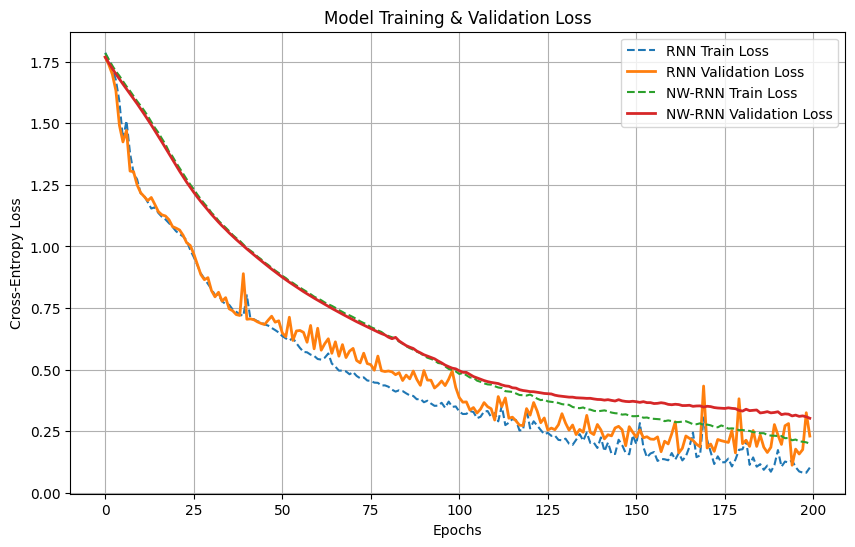

In [20]:
TRAIN_FILE_PATH = train_file_paths[1]
TEST_FILE_PATH = test_file_paths[1]
print(f"Running experiments for {names[1]} dataset")
train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes = run_experiment_rnn_models(TRAIN_FILE_PATH, TEST_FILE_PATH)


In [21]:
print(f"Running experiments for {names[1]} dataset")
run_experiment_esn_models(train_loader, test_loader, val_loader, std_rnn_classifier, nw_rnn_classifier, input_size, num_classes)    

Running experiments for Synthetic_Control dataset
Carrying out Hyperparameter search for ESN and NW-ESN networks:
Running experiments on device: cuda

--- 1. Starting NW-ESN Grid Search (from Table 3a) ---
Total combinations to check: 360


NW-ESN Grid Search:   0%|          | 0/360 [00:00<?, ?it/s]

--- NW-ESN Search Complete ---
Best NW-ESN Val Acc: 73.33%
Best NW-ESN Params: {'w': 1.0, 'beta': 0.1, 'p': 0.9, 'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0, 'rescale_s': 1.5, 'gamma': 1.0, 'delta_t': 0.001}

--- 2. Starting ESN Grid Search (from Table 3c) ---
Total combinations to check: 72


ESN Grid Search:   0%|          | 0/72 [00:00<?, ?it/s]

--- ESN Search Complete ---
Best ESN Val Acc: 51.67%
Best ESN Params: {'w': 1.0, 'beta': 0.001, 'p': 0.9, 'leaking_rate': 0.1}

--- 3. Final Evaluation on Test Set (using best models) ---


Testing NW-ESN:   0%|          | 0/5 [00:00<?, ?it/s]

  Model: NW-ESN
    -> Best Validation Accuracy: 73.33%
    -> Final Test Accuracy: 73.00%
    -> Best Params: {'w': 1.0, 'beta': 0.1, 'p': 0.9, 'Kp0': 0.0001, 'Kd0': 0.5, 'eta_p': 10.0, 'eta_d': 1.0, 'rescale_s': 1.5, 'gamma': 1.0, 'delta_t': 0.001}
------------------------------------------------------
--- Generating Final Model Comparison ---


Testing RNN:   0%|          | 0/5 [00:00<?, ?it/s]

Testing NW-RNN:   0%|          | 0/5 [00:00<?, ?it/s]

Testing NW-ESN:   0%|          | 0/5 [00:00<?, ?it/s]

Testing ESN:   0%|          | 0/5 [00:00<?, ?it/s]


--- Final Model Comparison Summary ---
Model           | Test Accuracy   | Total Params    | Trainable Params
---------------------------------------------------------------------------
ESN             | 45.00         % | 10,806          | 606            
NW-ESN (ours)   | 73.00         % | 10,806          | 606            
RNN             | 96.33         % | 10,906          | 10,906         
NW-RNN (ours)   | 94.67         % | 10,806          | 10,806         
--- Measuring Model Inference Time ---
Loaded full test set onto cuda (300 samples)
Time for RNN: 0.94 ms
Time for NW-RNN (ours): 24.55 ms
Time for ESN: 8.84 ms
Time for NW-ESN (ours): 19.91 ms

--- Full Test Set Inference Time ---
Model           | Time (ms)      
----------------------------------------
ESN             | 8.84           ms
NW-ESN (ours)   | 19.91          ms
RNN             | 0.94           ms
NW-RNN (ours)   | 24.55          ms
